# Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "drive/MyDrive/Colab Notebooks/mest"
%ls

/content/drive/MyDrive/Colab Notebooks/mest
 bin/                dataset_min_train/     src/
 checkpoints/        dist.pdf              'Zhukovsky (resize pos).ipynb'
 configs/            Identification.ipynb   КККМFOLDER_strokes_bin_ok.zip
 dataset_min/        norm.pdf
 dataset_min_test/   Potanin.ipynb


In [3]:
!unzip КККМFOLDER_strokes_bin_ok.zip -d "."

Streaming output truncated to the last 5000 lines.
  inflating: ./КККМFOLDER_strokes_bin_ok/Лаврская Антонина Викторовна/КККМ ОФ 7928:2672 Лаврская А # 40.png  
  inflating: ./КККМFOLDER_strokes_bin_ok/Лаврская Антонина Викторовна/КККМ ОФ 7928:2672 Лаврская А # 41.png  
  inflating: ./КККМFOLDER_strokes_bin_ok/Лаврская Антонина Викторовна/КККМ ОФ 7928:2672 Лаврская А # 43.png  
  inflating: ./КККМFOLDER_strokes_bin_ok/Лаврская Антонина Викторовна/КККМ ОФ 7928:2672 Лаврская А # 47.png  
  inflating: ./КККМFOLDER_strokes_bin_ok/Лаврская Антонина Викторовна/КККМ ОФ 7928:2673 Лаврская А # 17.png  
  inflating: ./КККМFOLDER_strokes_bin_ok/Лаврская Антонина Викторовна/КККМ ОФ 7928:2673 Лаврская А # 20.png  
  inflating: ./КККМFOLDER_strokes_bin_ok/Лаврская Антонина Викторовна/КККМ ОФ 7928:2673 Лаврская А # 24.png  
  inflating: ./КККМFOLDER_strokes_bin_ok/Лаврская Антонина Викторовна/КККМ ОФ 7928:2673 Лаврская А # 25.png  
  inflating: ./КККМFOLDER_strokes_bin_ok/Лаврская Антонина Викторовна

# Библиотеки

In [4]:
import os
import pickle
from collections import defaultdict

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set_theme()

import torch

from tqdm.notebook import tqdm as tqdm_n
from tqdm import tqdm
from functools import partial
from time import gmtime, strftime, time

from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix

from torchvision.transforms import v2
from torchvision.utils import save_image

# Code

## My_Dataset

In [23]:
# https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

class My_Folder(Dataset):
    def __init__(self, folder, transform, topk, skipNoName=True):
        super().__init__()

        self.folder = folder
        self.transform = transform

        self.dir_names = sorted(os.listdir(folder), reverse=True,
                                key=lambda i: len(os.listdir(os.path.join(folder, i)))) # ["000" , "001", ...]

        # self.dir_names = sorted(os.listdir(folder), reverse=False,
        #                         key=lambda i: len(os.listdir(os.path.join(folder, i)))) # ["000" , "001", ...]
        # self.dir_names = sorted(os.listdir(folder))

        if skipNoName and "Неустановленное лицо" in self.dir_names:
             self.dir_names.remove("Неустановленное лицо")

        if topk:
            self.dir_names = self.dir_names[:topk]

        self.num_cls = len(self.dir_names)

        self.dir2cls = {dir : i for i, dir in enumerate(self.dir_names)}
        self.cls2dir = {cls : dir for dir, cls in self.dir2cls.items()}

        self.dataset = [] # список всех путей до изображений

        self.cls2paths = defaultdict(list) # по cls получить все изображения класса

        for dir in self.dir_names:
            dir_path = os.path.join(folder, dir)

            for i in sorted(os.listdir(dir_path)):
                image_path = os.path.join(dir_path, i)
                cls = self.dir2cls[dir]

                self.dataset.append((image_path, cls))
                self.cls2paths[cls].append(image_path)

        self.cls2count = {cls : len(idxs) for cls, idxs in self.cls2paths.items()}
        self.dir2count = {self.cls2dir[cls] : count for cls, count in self.cls2count.items()}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path, cls = self.dataset[idx]
        image = self.transform(Image.open(image_path).convert("RGB"))

        return image, cls


class My_TripletFolder(My_Folder):

    def __getitem__(self, idx):
        anchor_path, cls = self.dataset[idx]
        anchor = self.transform(Image.open(anchor_path).convert("RGB"))

        positive_path = random.choice(self.cls2paths[cls])
        positive = self.transform(Image.open(positive_path).convert("RGB"))

        negative_cls = random.choice([i for i in range(self.num_cls) if i != cls])
        negative_path = random.choice(self.cls2paths[negative_cls])
        negative = self.transform(Image.open(negative_path).convert("RGB"))

        return anchor, positive, negative

In [24]:
arr = [1, 2, 3, 4, 5]
random.shuffle(arr)
arr

[2, 1, 5, 4, 3]

In [25]:
flags = [i < 10 for i in range(20)]
flags

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [26]:
random.shuffle(flags)
flags

[True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True]

In [27]:
class sub_Dataset(Dataset):
    def __init__(self, cls2dir, dir2paths, transform):
        super().__init__()

        self.cls2dir = {cls : dir for cls, dir in cls2dir.items() if dir in dir2paths} # вдруг папка dir пустая

        self.dir2paths = dir2paths
        self.transform = transform

        self.dir2cls = {dir : cls for cls, dir in self.cls2dir.items()}
        # print(self.dir2cls)
        self.cls2paths = {self.dir2cls[dir] : paths for dir, paths in self.dir2paths.items()}

        self.path2cls = defaultdict(int)
        for cls, paths in self.cls2paths.items():
            for path in paths:
                self.path2cls[path] = cls

        self.classes = [cls for cls in self.cls2dir]

        self.cls2count = {cls : len(idxs) for cls, idxs in self.cls2paths.items()}
        self.len_dataset = sum(self.cls2count.values())
        self.dir2count = {self.cls2dir[cls] : count for cls, count in self.cls2count.items()}

    def __len__(self):
        return self.len_dataset

    def __getitem__(self, idx):
        if idx >= self.len_dataset:
            raise IndexError

        cls = random.choice(self.classes)
        image_path = random.choice(self.cls2paths[cls])

        image = self.transform(Image.open(image_path).convert("RGB"))
        # image = None
        return image, cls


class sub_TripletDataset(sub_Dataset):
    def __getitem__(self, idx):
        cls = random.choice(self.classes)

        anchor_path = random.choice(self.cls2paths[cls])
        anchor = self.transform(Image.open(anchor_path).convert("RGB"))

        positive_path = random.choice(self.cls2paths[cls])
        positive = self.transform(Image.open(positive_path).convert("RGB"))

        negative_cls = random.choice([i for i in self.classes if i != cls])
        negative_path = random.choice(self.cls2paths[negative_cls])
        negative = self.transform(Image.open(negative_path).convert("RGB"))

        return anchor, positive, negative


def pre_init_dataset(folder, topk, skipNoName=True):
    dir_names = sorted(os.listdir(folder), reverse=True,
                            key=lambda i: len(os.listdir(os.path.join(folder, i)))) # ["000" , "001", ...]

    # dir_names = sorted(os.listdir(folder), reverse=False,
    #                         key=lambda i: len(os.listdir(os.path.join(folder, i)))) # ["000" , "001", ...]

    if skipNoName and "Неустановленное лицо" in dir_names:
            dir_names.remove("Неустановленное лицо")

    if topk:
        dir_names = dir_names[:topk]

    num_cls = len(dir_names)

    cls2dir = {i : dir for i, dir in enumerate(dir_names)}

    dir2paths = defaultdict(list) # по cls получить все изображения класса

    for dir in dir_names:
        dir_path = os.path.join(folder, dir)

        for i in sorted(os.listdir(dir_path)):
            image_path = os.path.join(dir_path, i)

            dir2paths[dir].append(image_path)

    return cls2dir, dir2paths


def split_dir2paths(dir2paths, percent):
    train_dir2paths, test_dir2paths = defaultdict(list), defaultdict(list)

    for dir, paths in dir2paths.items():
        num = len(paths)
        train_size = int(num * percent)

        flags = [i < train_size for i in range(len(paths))]
        random.shuffle(flags)
        # flags = [random.random() < percent for _ in paths]

        for i, f in enumerate(flags):
            if f:
                train_dir2paths[dir].append(paths[i])
            else:
                test_dir2paths[dir].append(paths[i])

    return train_dir2paths, test_dir2paths


def My_Balanced_split_dataset(folder, transform, topk, skipNoName=True, percent=0.8, type="siam"):
    cls2dir, dir2paths = pre_init_dataset(folder, topk, skipNoName)

    train_dir2paths, test_dir2paths = split_dir2paths(dir2paths, percent)

    if type == "siam":
        class_dataset = sub_TripletDataset
    else:
        class_dataset = sub_Dataset

    return class_dataset(cls2dir, train_dir2paths, transform), class_dataset(cls2dir, test_dir2paths, transform)

## Functions

In [28]:
def namefile(path):
        return path.split("/")[-1]


def ensemble(model_all, dataset, config, dir, n_epochs):
    d = evaluation(model_all, dataset, batch_size=config["batch_size"], device=config["device"], n_epochs=n_epochs)
    conf_matrix(d["y_items"], d["pred"], dataset.cls2dir, prop=False, title=f'acc: {d["acc"]:.6g}', savepath = os.path.join(dir, f"conf{n_epochs}.pdf"))
    conf_matrix(d["y_items"], d["pred"], dataset.cls2dir, prop=True, title=f'acc: {d["acc"]:.6g}', savepath = os.path.join(dir, f"conf{n_epochs}_prop.pdf"))
    fails = torch.where(d["y_items"] != d["pred"])[0]
    fails2file(dataset, d, fails, os.path.join(dir, f"fails{n_epochs}.txt"))


def ensemble_strokes(model_all, collate_fn, dataset, config, dir):
    d = evaluation(model_all, dataset, batch_size=config["batch_size"], collate_fn = collate_fn, device=config["device"])

    paths = [i[0] for i in dataset.dataset]
    paths2prob = {}
    for path, prob in zip(paths, d["prob"]):
        paths2prob[path] = prob

    images2strokes = defaultdict(list)
    for path in paths:
        # path ~ КККМ ОФ 7928:98 Агафонов # 2.png
        _, cls, picname = path.split("/")
        picname = os.path.splitext(picname)[0]
        name, _ = picname.split(" # ")
        images2strokes[name].append((path, cls))

    list_prob = []
    list_pred = []
    list_true = []
    list_images = []

    # print(images2strokes)
    # raise

    for image, paths in images2strokes.items():
        paths, classes = zip(*paths)
        cls = classes[0]

        list_probs = [paths2prob[path] for path in paths]
        list_probs = torch.vstack(list_probs)
        prob = torch.mean(list_probs, dim=0)
        pred = torch.argmax(prob).item()
        true = dataset.dir2cls[cls]

        list_images.append(image)
        list_prob.append(prob)
        list_pred.append(pred)
        list_true.append(true)


    list_pred = torch.tensor(list_pred)
    list_true = torch.tensor(list_true)

    d["y_items"], d["pred"], d["acc"] = list_true, list_pred, torch.mean((list_pred == list_true).float()).cpu().item() * 100
    d["prob"] = list_prob

    conf_matrix(d["y_items"], d["pred"], dataset.cls2dir, prop=False, title=f'acc: {d["acc"]:.6g}', savepath = os.path.join(dir, f"conf.pdf"))
    conf_matrix(d["y_items"], d["pred"], dataset.cls2dir, prop=True, title=f'acc: {d["acc"]:.6g}', savepath = os.path.join(dir, f"conf_prop.pdf"))
    fails = torch.where(d["y_items"] != d["pred"])[0]
    fails2file_strokes(list_images, dataset.cls2dir, d, fails, os.path.join(dir, "fails.txt"))


def fails2file_strokes(list_images, cls2dir, d, fails, file):
    if os.path.exists(file):
        !rm "{file}"
        print(f"Delete {file}")

    write2file(file, f'Fails num: {len(fails)} out of {len(list_images)}, accuracy: {d["acc"]:.6g}\n')
    for num, i in enumerate(fails):
        write2file(file, f'{num}: {list_images[i]}')
        y_item = d["y_items"][i].item()
        pred = d["pred"][i].item()
        prob = d["prob"][i].numpy()

        write2file(file, f'True/Pred: {y_item} / {pred}, {cls2dir[y_item]} / {cls2dir[pred]}')

        args = np.argsort(prob)[::-1]
        place = np.where(args == y_item)[0][0] + 1

        write2file(file, f'Prob: {prob[pred]:.4f}, Place: {place}')

        args = args[:3]
        # print(f'Distr:{prob}')

        for k in args:
            write2file(file, f'{prob[k]:.4f} {cls2dir[k]}')

        write2file(file, "\n")


def fails2file(dataset, d, fails, file):
    if os.path.exists(file):
        !rm "{file}"
        print(f"Delete {file}")

    write2file(file, f'Fails num: {len(fails)} out of {len(dataset)}, accuracy: {d["acc"]:.6g}\n')
    for num, i in enumerate(fails):
        write2file(file, f'{num}: {dataset.dataset[i][0]}')
        y_item = d["y_items"][i].item()
        pred = d["pred"][i].item()
        prob = d["prob"][i].numpy()

        write2file(file, f'True/Pred: {y_item} / {pred}, {dataset.cls2dir[y_item]} / {dataset.cls2dir[pred]}')

        args = np.argsort(prob)[::-1]
        place = np.where(args == y_item)[0][0] + 1

        write2file(file, f'Prob: {prob[pred]:.4f}, Place: {place}')

        args = args[:3]
        # print(f'Distr:{prob}')

        for k in args:
            write2file(file, f'{prob[k]:.4f} {dataset.cls2dir[k]}')

        write2file(file, "\n")


class Pipeline(nn.Module):
    def __init__(self, model, cl):
        super().__init__()
        self.model = model
        self.cl = cl

    def forward(self, x):
        x = self.model(x)
        x = self.cl(x)
        return x


def test_pipeline(model, dataset, device, batch_size, collate_fn=None, type="siam"):

    print("--- test_pipeline:")

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    for batch in loader:
        if type == "siam":
            anchor, positive, negative = [d.to(device) for d in batch]
            anchor_output = model(anchor)
            positive_output = model(positive)
            negative_output = model(negative)

            print(f"anchor: {anchor.shape}\nmodel:   {anchor_output.shape}")
        else:

            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            print(X_batch.shape, batch_size)

            output = model(X_batch) # torch.Size([BATCH, NUM_CLS])
            print(f"X_batch: {X_batch.shape}\ny_batch: {y_batch.shape}\nmodel:   {output.shape}")

        break

    print("--- test_pipeline end")


def create_model(model, num_not_freeze_layers, num_out_classes):
    # замена последнего слоя сети
    model.fc = nn.Linear(512, num_out_classes)

    num_freeze_layers = len(list(model.children())) - num_not_freeze_layers
    # заморозка слоев
    for i, layer in enumerate(model.children()):
        if i < num_freeze_layers:
            for param in layer.parameters():
                param.requires_grad = False
        else:
            for param in layer.parameters():
                param.requires_grad = True

    return model


def my_round(x, n):
    new_x = f"{{:.{n-1}g}}".format(x)

    if len(new_x) < n:
        new_x = " " * (n - len(new_x)) + new_x
    return new_x


def recur_paths(dir):
    ans = []

    for img in os.listdir(dir):
        x = os.path.join(dir, img)
        if os.path.isdir(x):
            ans.extend(recur_paths(x))
        else:
            ans.append(x)
    return ans


def save_logs(logs, path):
    with open(path, "wb") as f:
        pickle.dump(logs, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_logs(path):
    with open(path, "rb") as f:
        logs = pickle.load(f)

    return logs

def write2file(file, text):
    with open(file, 'a') as f:
        f.write(text + "\n")

def my_time():
    return strftime("%Y-%m-%d %H:%M:%S", gmtime(time() + 3 * 60 * 60))

def my_timediff(start_time):
    return strftime("%H:%M:%S", gmtime(time() - start_time))


def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def ToModel(model, device):
    def fun(tensor, model=model, device=device):
        return model(tensor[None, :].to(device))[0]
    return fun


def Min_size(size):
    def fun(tensor, size=size):
        c, h, w = tensor.shape
        new_h = size
        new_w = int(w * new_h / h)

        res = transforms.Resize((new_h, new_w))(tensor)
        return res

    return fun


def split_dataset(dataset, percent):
    train_size = int(len(dataset) * percent)
    val_size = len(dataset) - train_size

    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )

    len_tr, len_test = len(train_dataset), len(test_dataset)
    # print(f"split_dataset: Train: {len_tr} Test: {len_test} Total: {len_tr + len_test}")

    return train_dataset, test_dataset

In [29]:
x = []

num_epochs = 3
num_bathes = 6
for n in range(num_epochs):
    for i in range(n * num_bathes, (n + 1) * num_bathes):
        x.append(torch.full((4, 2, 3), i))

x = torch.cat(x)


num, *s = x.shape
print(x.shape, num, s)

x = x.reshape(num_epochs, num // num_epochs, *s)
x.shape

torch.Size([72, 2, 3]) 72 [2, 3]


torch.Size([3, 24, 2, 3])

In [30]:
x = []

num_epochs = 3
num_bathes = 5
for n in range(num_epochs):
    for i in range(n * num_bathes, (n + 1) * num_bathes):
        x.append(torch.full((4, 2, 3), i))

x = torch.cat(x)

In [31]:
num, *s = x.shape
print(x.shape, num, s)

torch.Size([60, 2, 3]) 60 [2, 3]


In [32]:
x = x.reshape(num_epochs, num // num_epochs, *s)
x.shape

torch.Size([3, 20, 2, 3])

In [33]:
x[0]

tensor([[[0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0]],

        [[1, 1, 1],
         [1, 1, 1]],

        [[1, 1, 1],
         [1, 1, 1]],

        [[1, 1, 1],
         [1, 1, 1]],

        [[1, 1, 1],
         [1, 1, 1]],

        [[2, 2, 2],
         [2, 2, 2]],

        [[2, 2, 2],
         [2, 2, 2]],

        [[2, 2, 2],
         [2, 2, 2]],

        [[2, 2, 2],
         [2, 2, 2]],

        [[3, 3, 3],
         [3, 3, 3]],

        [[3, 3, 3],
         [3, 3, 3]],

        [[3, 3, 3],
         [3, 3, 3]],

        [[3, 3, 3],
         [3, 3, 3]],

        [[4, 4, 4],
         [4, 4, 4]],

        [[4, 4, 4],
         [4, 4, 4]],

        [[4, 4, 4],
         [4, 4, 4]],

        [[4, 4, 4],
         [4, 4, 4]]])

In [34]:
x[2]

tensor([[[10, 10, 10],
         [10, 10, 10]],

        [[10, 10, 10],
         [10, 10, 10]],

        [[10, 10, 10],
         [10, 10, 10]],

        [[10, 10, 10],
         [10, 10, 10]],

        [[11, 11, 11],
         [11, 11, 11]],

        [[11, 11, 11],
         [11, 11, 11]],

        [[11, 11, 11],
         [11, 11, 11]],

        [[11, 11, 11],
         [11, 11, 11]],

        [[12, 12, 12],
         [12, 12, 12]],

        [[12, 12, 12],
         [12, 12, 12]],

        [[12, 12, 12],
         [12, 12, 12]],

        [[12, 12, 12],
         [12, 12, 12]],

        [[13, 13, 13],
         [13, 13, 13]],

        [[13, 13, 13],
         [13, 13, 13]],

        [[13, 13, 13],
         [13, 13, 13]],

        [[13, 13, 13],
         [13, 13, 13]],

        [[14, 14, 14],
         [14, 14, 14]],

        [[14, 14, 14],
         [14, 14, 14]],

        [[14, 14, 14],
         [14, 14, 14]],

        [[14, 14, 14],
         [14, 14, 14]]])

## Trainer

In [35]:
def conf_matrix(y_true, y_pred, cls2dir, prop, title, savepath=None):
    cm = confusion_matrix(y_true, y_pred)

    if prop:
        cm = cm / len(y_true) * 100

    plt.figure(figsize=(5, 5))
    labels = [cls2dir[i] for i in sorted(cls2dir.keys())]

    # fmt = 'f' if prop else 'd'
    fmt = '.4g'
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', xticklabels=labels, yticklabels=labels)

    plt.xlabel("Prediction")
    plt.ylabel("True")
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Confusion Matrix, {title}")

    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()
    # return cm

def evaluation_siam(model, dataloader):
    total_loss = 0
    correct = 0
    total = 0

    ans = []
    true = []

    with torch.no_grad():
        for batch in dataloader:

            anchor, positive, negative = [d.to(DEVICE) for d in batch]
            anchor_output = model(anchor)
            positive_output = model(positive)
            negative_output = model(negative)

            correct += (
                (torch.norm(anchor_output - positive_output, dim=1)
                < torch.norm(anchor_output - negative_output, dim=1)).sum()
                )
            total += anchor.size(0)

    return correct / total * 100


def reshape_epoches(x, n_epochs):
    """
    x ~ (n_epochs * n_elem, *)
    return x ~ (n_epochs, n_elem, *)
    """
    num, *s = x.shape

    x = x.reshape(n_epochs, num // n_epochs, *s)
    return x


def evaluation(model, dataset, batch_size, collate_fn, device, n_epochs=1):

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    pred = []
    prob = []
    y_items = []
    x_items = []

    with torch.no_grad():
        for _ in range(n_epochs):
            for batch in dataloader:

                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                x_items.append(X_batch)
                y_items.append(y_batch)

                output = model(X_batch)
                y_pred = torch.argmax(output, dim=1)
                pred.append(y_pred)

                y_prob = torch.softmax(output, dim=1)
                prob.append(y_prob)

    pred = torch.cat(pred).cpu()
    prob = torch.cat(prob).cpu()
    y_items = torch.cat(y_items).cpu()
    try:
        x_items = torch.cat(x_items).cpu()
    except:
        pass

    d = {"pred" : pred,
        "prob" : prob,
        "y_items" : y_items,
        "x_items" : x_items}

    if n_epochs != 1:
        for key in d:
            d[key] = reshape_epoches(d[key], n_epochs)
            if key == "prob":
                d[key] = d[key].mean(dim=0)
            elif key == "y_items":
                d[key] = d[key].mode(dim=0).values

        d["pred"] = torch.argmax(d["prob"], dim=1)

    d["acc"] = torch.mean((d["pred"] == d["y_items"]).float()).cpu().item() * 100
    # d["pred"], d["prob"], d["y_items"], d["x_items"], d["acc"]
    return d


def load_model(model, path):
    print(f"load_model: {path}")
    model.load_state_dict(torch.load(path, map_location=DEVICE))


def load_best_model(model, dir):
    file = "logs.pickle"
    path = os.path.join(dir, file)

    logs = load_logs(path)
    argmax_val_acc = logs["max_val_acc"]["arg"]
    load_model(model, os.path.join(dir, "epochs", f"{argmax_val_acc} epoch.pt"))
    return model

DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

class Trainer:
    def __init__(
            self,
            model,
            optimizer,
            criterion,
            type,
            name,
            device,
            dir="logs",
            early_stopping=10,
    ):
        os.makedirs(dir, exist_ok=True)

        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.name = name
        self.stop = early_stopping
        self.savedir = os.path.join(dir, f"{my_time()} {self.name}") # название папки для сохранения
        self.savedir_epochs = os.path.join(self.savedir, "epochs") # "1 epoch.pt"
        self.savedir_logs_dict = os.path.join(self.savedir, "logs.pickle")
        self.savedir_logs_txt = os.path.join(self.savedir, "logs.txt")
        self.savedir_epochs_fun = lambda i : f"{self.savedir_epochs}/{i} epoch.pt"
        self.not_decrease = "Val losses doesn`t decrease!"
        self.message_fun = (lambda cur_time, epoch, train_loss, val_loss, train_acc, val_acc
                            : f"{cur_time} epoch: {epoch:4}, train/val loss = {train_loss:.5f} / {val_loss:.5f}, acc = {train_acc:.7} / {val_acc:.7}")
        self.disable = False

        if type == "siam":
            self._train_step = self._train_step_siam
            self._eval_step = self._eval_step_siam

        if os.path.exists(self.savedir):
            raise TypeError(f"{self.savedir} exists!!!")

        os.makedirs(self.savedir, exist_ok=True)
        print(f"Make {self.savedir}")
        os.makedirs(self.savedir_epochs, exist_ok=False)

        self._n_epoch = 0

        self.logs = {
            "time":  [],
            "epoch": [],
            "train_loss":   [],
            "val_loss":     [],
            "train_acc":    [],
            "val_acc":      [],
            "min_train_loss":   {"arg" : None, "value" : float("inf")},
            "min_val_loss":     {"arg" : None, "value" : float("inf")},
            "max_train_acc":    {"arg" : None, "value" : -1},
            "max_val_acc":      {"arg" : None, "value" : -1},
        }

    def add_log(self, **args): # Добавить в self.logs словарь args
        for key in self.logs:
            if key not in args:
                print(f"{key} not in {list(args.keys())}")
            else: # key in args
                if type(self.logs[key]) is list:
                    self.logs[key].append(args[key])
                else:

                    if key[:3] == "min": # loss
                        if args[key]["value"] <= self.logs[key]["value"]:
                            self.logs[key] = args[key]
                    elif key[:3] == "max": # acc
                        if args[key]["value"] >= self.logs[key]["value"]:
                            self.logs[key] = args[key]

    def print_best(self): # Информация о лучшем loss и accuracy
        mes  = ["train loss", "val loss  ", "train acc ", "val acc   "]
        keys = ["min_train_loss", "min_val_loss", "max_train_acc", "max_val_acc"]

        ans = []
        for key, m in zip(keys, mes):
            idx = self.logs[key]["arg"]
            value = self.logs[key]["value"]

            ans.append(f"Best {m} = {my_round(value, 10)} on {idx:4} epoch")

        return "\n".join(ans)


    def train(self, train_loader, val_loader, n_epochs):

        start_time = time()

        val_losses = self.logs["val_loss"]

        for epoch in tqdm_n(range(n_epochs), disable=False):

            train_loss, train_acc = self._train_step(train_loader)
            val_loss, val_acc = self._eval_step(val_loader)

            if not self.disable:
                self.disable = True

            cur_time = my_timediff(start_time)

            string = self.message_fun(cur_time, self._n_epoch, train_loss, val_loss, train_acc, val_acc)
            print(string)
            write2file(self.savedir_logs_txt, string)

            args = {
                "time": cur_time,
                "epoch": self._n_epoch,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "min_train_loss":   {"arg" : self._n_epoch, "value" : train_loss},
                "min_val_loss":     {"arg" : self._n_epoch, "value" : val_loss},
                "max_train_acc":    {"arg" : self._n_epoch, "value" : train_acc},
                "max_val_acc":      {"arg" : self._n_epoch, "value" : val_acc},
            }
            self.add_log(**args)

            torch.save(self.model.state_dict(), self.savedir_epochs_fun(epoch))
            save_logs(self.logs, self.savedir_logs_dict)

            if len(val_losses) > self.stop and min(val_losses[-self.stop:]) > val_losses[-self.stop-1]:
                print(self.not_decrease)
                write2file(self.savedir_logs_txt, self.not_decrease)

            self._n_epoch += 1

        string = self.print_best()
        print(string)
        write2file(self.savedir_logs_txt, string)

        print("Training completed\n")
        return self.savedir


    def _train_step(self, dataloader):
        self.model.train()

        total_loss = 0
        correct = 0
        total = 0

        for batch in tqdm_n(dataloader, disable=self.disable):

            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

            output = self.model(X_batch) # torch.Size([BATCH, NUM_CLS])
            loss = self.criterion(output, y_batch)

            y_pred = torch.argmax(output, dim=1)
            correct += torch.sum(y_pred == y_batch)
            total += len(y_batch)

            total_loss += loss
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

        return total_loss.item() / len(dataloader), correct.item() / total * 100


    def _eval_step(self, dataloader):
        self.model.eval()

        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in tqdm_n(dataloader, disable=self.disable):

                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                output = self.model(X_batch)
                loss = self.criterion(output, y_batch)

                y_pred = torch.argmax(output, dim=1)
                correct += torch.sum(y_pred == y_batch)
                total += len(y_batch)

                total_loss += loss

        return total_loss.item() / len(dataloader), correct.item() / total * 100


    def _train_step_siam(self, dataloader):
        total_loss = 0
        correct = 0
        total = 0

        for batch in tqdm_n(dataloader, disable=self.disable):

            anchor, positive, negative = [d.to(self.device) for d in batch]
            anchor_output = self.model(anchor)
            positive_output = self.model(positive)
            negative_output = self.model(negative)

            loss = self.criterion(anchor_output, positive_output, negative_output)

            correct += (
                (torch.norm(anchor_output - positive_output, dim=1)
                 < torch.norm(anchor_output - negative_output, dim=1)).sum()
                 )
            total += anchor.size(0)

            total_loss += loss

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

        return total_loss.item() / len(dataloader), correct.item() / total * 100


    def _eval_step_siam(self, dataloader):
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in tqdm_n(dataloader, disable=self.disable):

                anchor, positive, negative = [d.to(self.device) for d in batch]
                anchor_output = self.model(anchor)
                positive_output = self.model(positive)
                negative_output = self.model(negative)

                loss = self.criterion(anchor_output, positive_output, negative_output)

                correct += (
                    (torch.norm(anchor_output - positive_output, dim=1)
                    < torch.norm(anchor_output - negative_output, dim=1)).sum()
                    )
                total += anchor.size(0)

                total_loss += loss

        return total_loss.item() / len(dataloader), correct.item() / total * 100

Device: cuda


# Experiments

In [ ]:
def experiment(config):
    print(f'Device: {config["device"]}')

    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model = create_model(model,
                            num_not_freeze_layers=config["num_not_freeze_layers"],
                            num_out_classes=config["siam_emb_dim"]).to(config["device"])

    print(f"Siam model parameters number: {number_of_parameters(model)}")

    transform = transforms.Compose(
    [
            transforms.RandomCrop(300),
            transforms.ToTensor(),
    ])

    if not config["balanced"]:
        dataset = My_TripletFolder(config["folder"], transform=transform, topk=config["dataset_topk"])
        print(f"\nDataset length: {len(dataset)}")
        for key, value in dataset.dir2count.items():
            print(f"{key}   :   {value}")
        print()

        train_dataset, test_dataset = split_dataset(dataset, percent=config["split_percent"])
        print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")
    else:
        train_dataset, test_dataset = My_Balanced_split_dataset(config["folder"], transform=transform, topk=config["dataset_topk"],
                                                                percent=config["split_percent"], type="siam")

        print("\ntrain dataset")
        for key, value in train_dataset.dir2count.items():
            print(f"{key}   :   {value}")
        print()

        print("test dataset")
        for key, value in test_dataset.dir2count.items():
            print(f"{key}   :   {value}")
        print()

        print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")

    test_pipeline(model, train_dataset, device=config["device"], batch_size=config["batch_size"], type = "siam")

    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    criterion = torch.nn.TripletMarginLoss(margin=9, p=2)

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

    x = '_balanced' if config["balanced"] else ""
    trainer = Trainer(model, optimizer, criterion, type = "siam", name = f'siam_{config["type"]}{config["dataset_topk"]}{x}', device=config["device"])
    dir = trainer.train(train_loader, val_loader, n_epochs = config["siam_epochs"])
    # end siam train

    model = load_best_model(model, dir=dir)
    print(f"train/val acc : {evaluation_siam(model, train_loader)} / {evaluation_siam(model, val_loader)}")

    model.eval()
    for p in model.parameters():
        p.requires_grad = False
    print(f"Siam model parameters number: {number_of_parameters(model)}")

    # start cl train
    cl_model = nn.Sequential(nn.Linear(config["siam_emb_dim"], 512), nn.ReLU(), nn.Linear(512, config["dataset_topk"])).to(DEVICE)
    print(f"Class model parameters number: {number_of_parameters(cl_model)}")

    transform = transforms.Compose(
        [
                transforms.RandomCrop(300),
                transforms.ToTensor(),
                ToModel(model, DEVICE),
        ])

    if not config["balanced"]:
        dataset = My_Folder(config["folder"], transform, topk=config["dataset_topk"])
        print(f"Dataset length: {len(dataset)}")
        train_dataset, test_dataset = split_dataset(dataset, percent=config["split_percent"])
        print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}\n")
    else:
        train_dataset, test_dataset = My_Balanced_split_dataset(config["folder"], transform=transform, topk=config["dataset_topk"],
                                                                percent=config["split_percent"], type="not siam")
        print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")

    test_pipeline(cl_model, train_dataset, device=config["device"], batch_size=config["batch_size"], type = "not siam")

    optimizer = torch.optim.Adam(cl_model.parameters(), lr=3e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

    trainer = Trainer(cl_model, optimizer, criterion, type = "not siam", name = f'cl_{config["type"]}{config["dataset_topk"]}{x}', device=config["device"])
    dir = trainer.train(train_loader, val_loader, n_epochs = config["cl_epochs"])

    cl_model.eval()
    for p in cl_model.parameters():
        p.requires_grad = False
    print(f"Class model parameters number: {number_of_parameters(cl_model)}")
    # end cl train

    # ensemble
    model_all = Pipeline(model, cl_model).to(config["device"])
    print(f"Model parameters number: {number_of_parameters(model_all)}")

    transform = transforms.Compose(
    [
            transforms.RandomCrop(300),
            transforms.ToTensor(),
    ])
    dataset = My_Folder(config["folder"], transform, topk=config["dataset_topk"])

    ensemble(model_all, dataset, config, dir, n_epochs=1)
    ensemble(model_all, dataset, config, dir, n_epochs=5)
    ensemble(model_all, dataset, config, dir, n_epochs=10)

## Windows

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(DEVICE)
number_of_parameters(model)
# model

11689512

In [ ]:
for i in model.children():
    print(number_of_parameters(i))

9408
128
0
0
147968
525568
2099712
8393728
0
513000


### 3 class

Device: cuda
Siam model parameters number: 513000

Dataset length: 177
Фарафонтова Таисия Михайловна   :   67
Потанина Александра Викторовна   :   62
Ивановский Алексей Осипович   :   48

train dataset: 141, test dataset: 36
--- test_pipeline:
anchor: torch.Size([64, 3, 300, 300])
model:   torch.Size([64, 1000])
--- test_pipeline end
Make logs/2025-04-21 12:12:19 siam_window3


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

00:00:06 epoch:    0, train/val loss = 7.60249 / 7.92774, acc = 74.46809 / 69.44444
00:00:12 epoch:    1, train/val loss = 6.68459 / 6.73780, acc = 74.46809 / 72.22222
00:00:18 epoch:    2, train/val loss = 6.54317 / 6.23698, acc = 78.01418 / 77.77778
00:00:24 epoch:    3, train/val loss = 6.36281 / 5.73835, acc = 73.75887 / 83.33333
00:00:30 epoch:    4, train/val loss = 6.27973 / 6.09077, acc = 75.1773 / 72.22222
00:00:36 epoch:    5, train/val loss = 5.36585 / 5.49298, acc = 76.59574 / 72.22222
00:00:41 epoch:    6, train/val loss = 5.16614 / 6.18681, acc = 78.7234 / 75.0
00:00:47 epoch:    7, train/val loss = 4.29898 / 5.03744, acc = 86.52482 / 83.33333
00:00:52 epoch:    8, train/val loss = 4.37856 / 4.33040, acc = 84.39716 / 88.88889
00:00:59 epoch:    9, train/val loss = 4.01097 / 4.14993, acc = 78.01418 / 80.55556
00:01:04 epoch:   10, train/val loss = 4.28413 / 6.06697, acc = 85.10638 / 75.0
00:01:13 epoch:   11, train/val loss = 4.70898 / 5.45432, acc = 83.68794 / 72.22222
00

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

00:00:02 epoch:    0, train/val loss = 0.88787 / 0.65439, acc = 49.64539 / 77.77778
00:00:04 epoch:    1, train/val loss = 0.61425 / 0.59067, acc = 82.2695 / 77.77778
00:00:07 epoch:    2, train/val loss = 0.47159 / 0.56355, acc = 82.97872 / 77.77778
00:00:09 epoch:    3, train/val loss = 0.40489 / 0.46190, acc = 82.2695 / 86.11111
00:00:11 epoch:    4, train/val loss = 0.39064 / 0.45054, acc = 87.23404 / 80.55556
00:00:13 epoch:    5, train/val loss = 0.47849 / 0.47989, acc = 85.10638 / 88.88889
00:00:15 epoch:    6, train/val loss = 0.45279 / 0.51742, acc = 85.8156 / 77.77778
00:00:18 epoch:    7, train/val loss = 0.33792 / 0.45481, acc = 90.07092 / 88.88889
00:00:20 epoch:    8, train/val loss = 0.44566 / 0.38689, acc = 86.52482 / 91.66667
00:00:22 epoch:    9, train/val loss = 0.36174 / 0.30562, acc = 85.8156 / 91.66667
00:00:24 epoch:   10, train/val loss = 0.32588 / 0.41530, acc = 89.3617 / 80.55556
00:00:26 epoch:   11, train/val loss = 0.36345 / 0.43101, acc = 87.94326 / 86.111

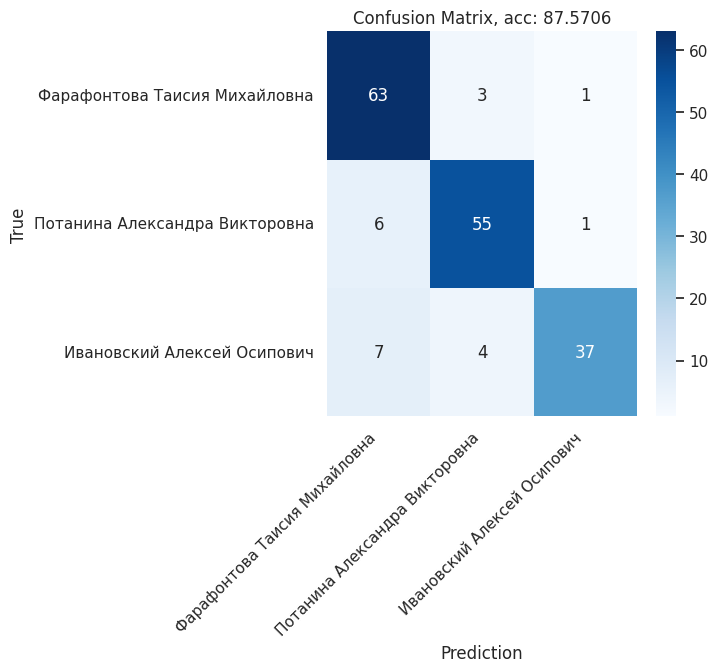

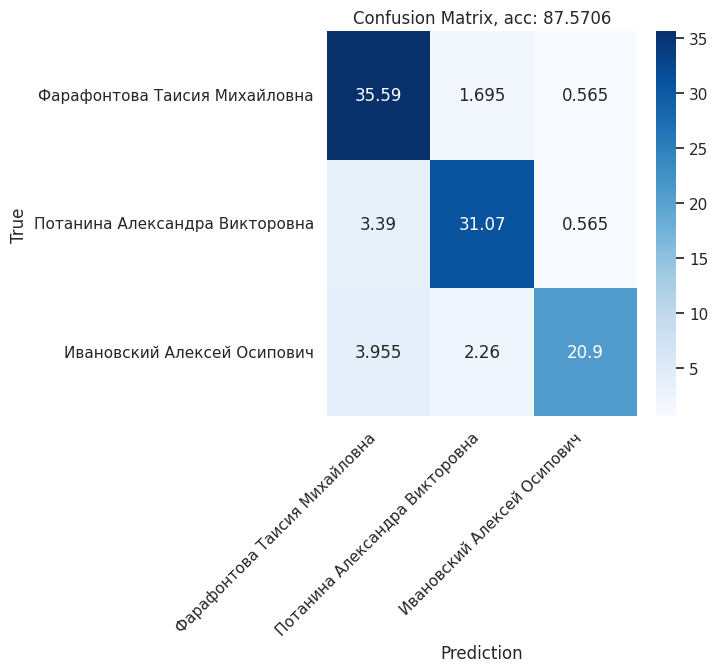

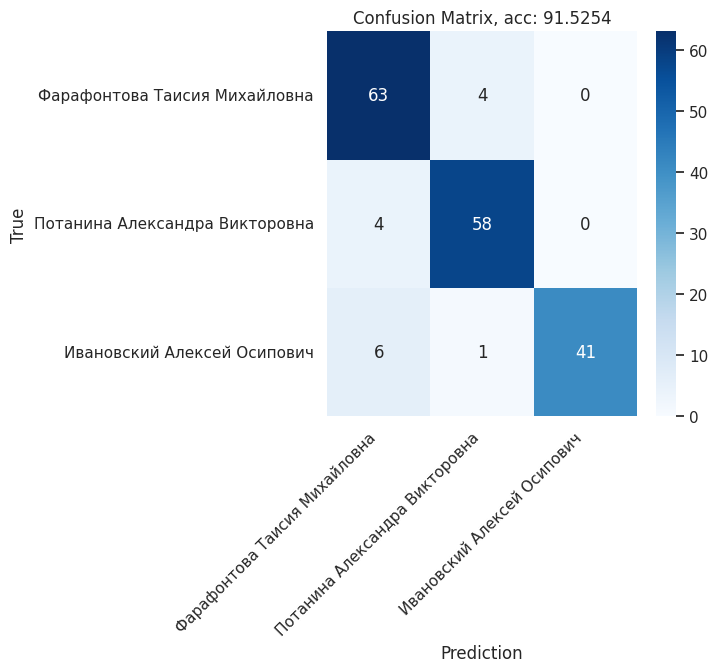

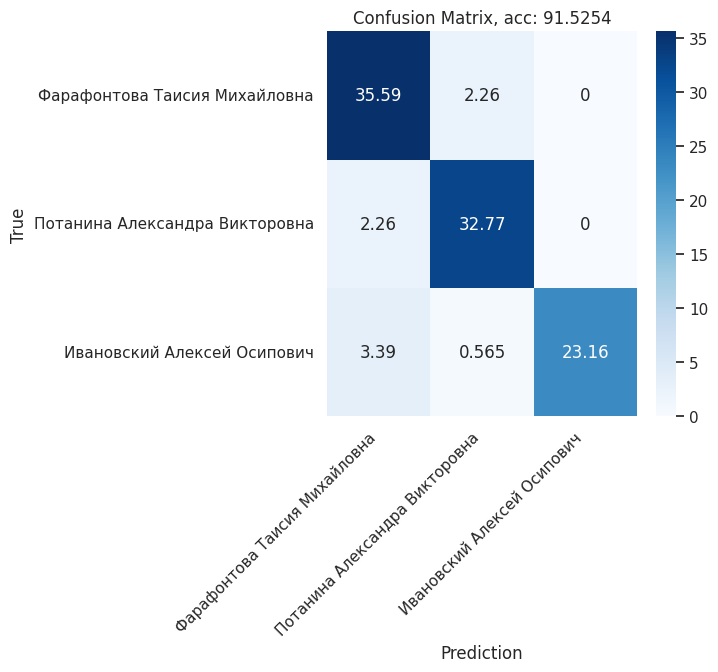

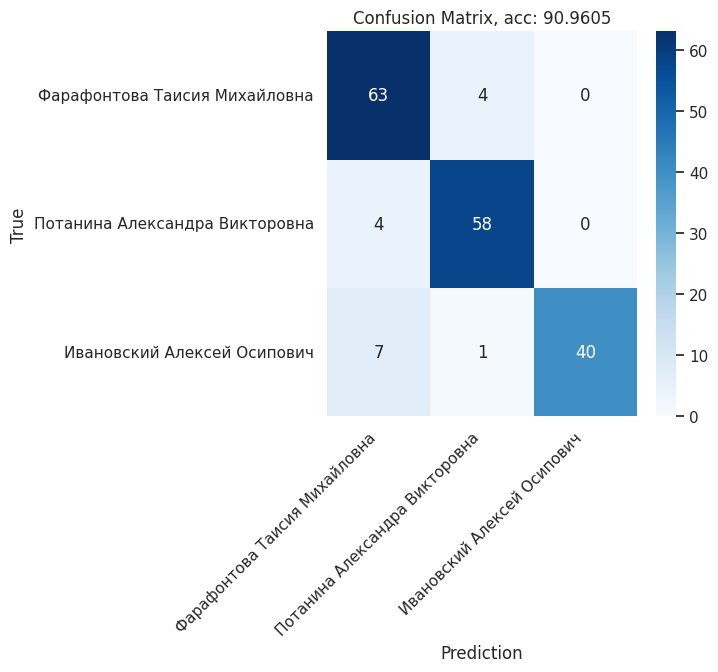

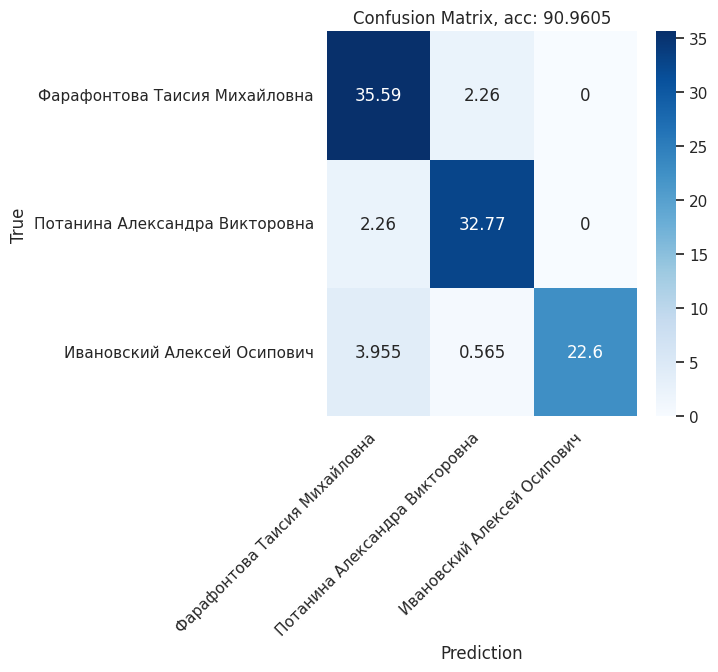

In [ ]:
config = {
    "device" : DEVICE,

    "type" : "window",
    "siam_emb_dim" : 1000,
    "num_not_freeze_layers" : 1,

    "dataset_topk" : 3,
    "folder" : "КККМFOLDER_bin",
    "split_percent" : 0.8,

    "balanced" : False,
    "batch_size" : 64,
    "siam_epochs" : 30,
    "cl_epochs" : 20,
}

experiment(config)

Device: cuda
Siam model parameters number: 513000

train dataset
Фарафонтова Таисия Михайловна   :   53
Потанина Александра Викторовна   :   49
Ивановский Алексей Осипович   :   38

test dataset
Фарафонтова Таисия Михайловна   :   14
Потанина Александра Викторовна   :   13
Ивановский Алексей Осипович   :   10

train dataset: 140, test dataset: 37
--- test_pipeline:
anchor: torch.Size([64, 3, 300, 300])
model:   torch.Size([64, 1000])
--- test_pipeline end
Make logs/2025-04-21 12:16:43 siam_window3_True


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

00:00:05 epoch:    0, train/val loss = 7.60312 / 7.94949, acc = 73.57143 / 72.97297
00:00:11 epoch:    1, train/val loss = 7.31294 / 8.60605, acc = 75.71429 / 62.16216
00:00:17 epoch:    2, train/val loss = 6.86443 / 6.10573, acc = 79.28571 / 89.18919
00:00:22 epoch:    3, train/val loss = 5.61932 / 7.30218, acc = 82.85714 / 64.86486
00:00:28 epoch:    4, train/val loss = 5.21402 / 6.21533, acc = 77.14286 / 67.56757
Best train loss = 5.21401946 on    4 epoch
Best val loss   = 6.10573244 on    2 epoch
Best train acc  = 82.8571429 on    3 epoch
Best val acc    = 89.1891892 on    2 epoch
Training completed

load_model: logs/2025-04-21 12:16:43 siam_window3_True/epochs/2 epoch.pt
train/val acc : 87.85714721679688 / 72.97297668457031
Siam model parameters number: 0
Class model parameters number: 514051
train dataset: 140, test dataset: 37
--- test_pipeline:
torch.Size([64, 1000]) 64
X_batch: torch.Size([64, 1000])
y_batch: torch.Size([64])
model:   torch.Size([64, 3])
--- test_pipeline end


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

00:00:02 epoch:    0, train/val loss = 0.98775 / 0.71280, acc = 39.28571 / 91.89189
00:00:04 epoch:    1, train/val loss = 0.83413 / 0.75201, acc = 76.42857 / 70.27027
00:00:06 epoch:    2, train/val loss = 0.70779 / 0.71796, acc = 79.28571 / 54.05405
00:00:09 epoch:    3, train/val loss = 0.62946 / 0.58833, acc = 65.0 / 72.97297
00:00:11 epoch:    4, train/val loss = 0.48606 / 0.55174, acc = 87.14286 / 78.37838
Best train loss = 0.486062328 on    4 epoch
Best val loss   = 0.551738918 on    4 epoch
Best train acc  = 87.1428571 on    4 epoch
Best val acc    = 91.8918919 on    0 epoch
Training completed

Class model parameters number: 0
Model parameters number: 0


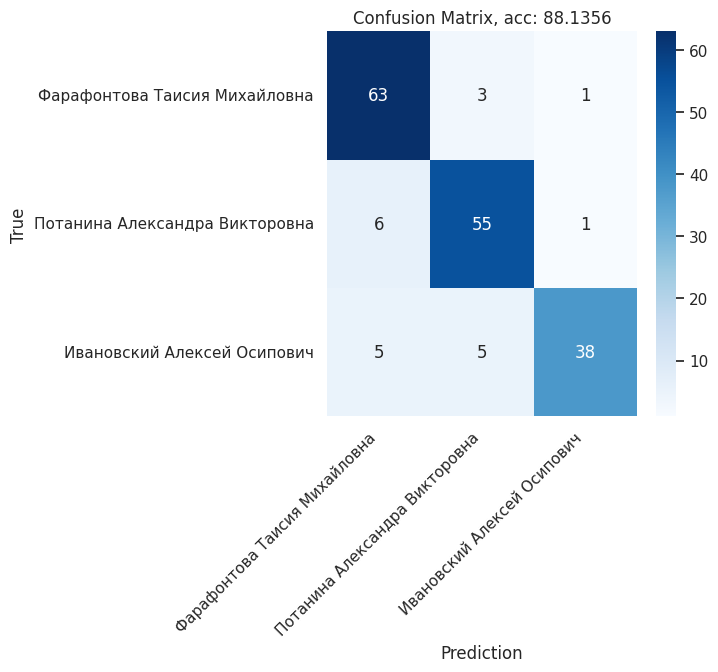

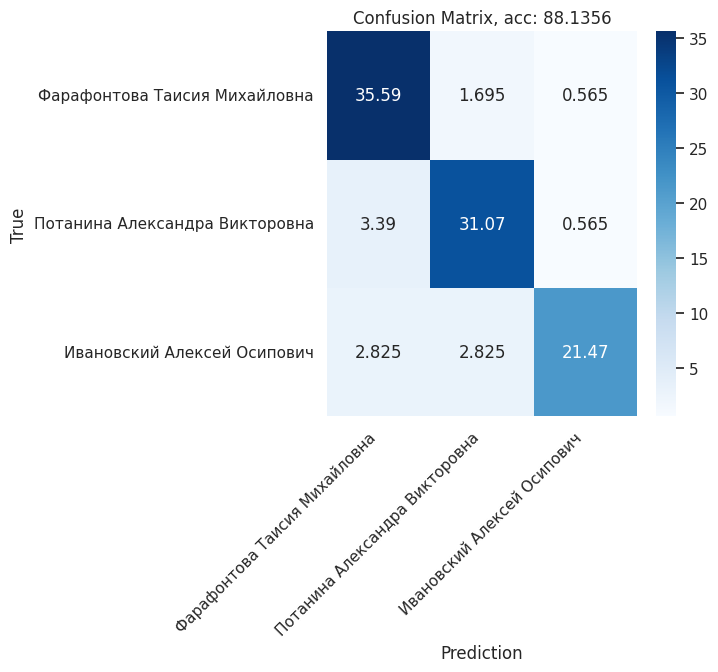

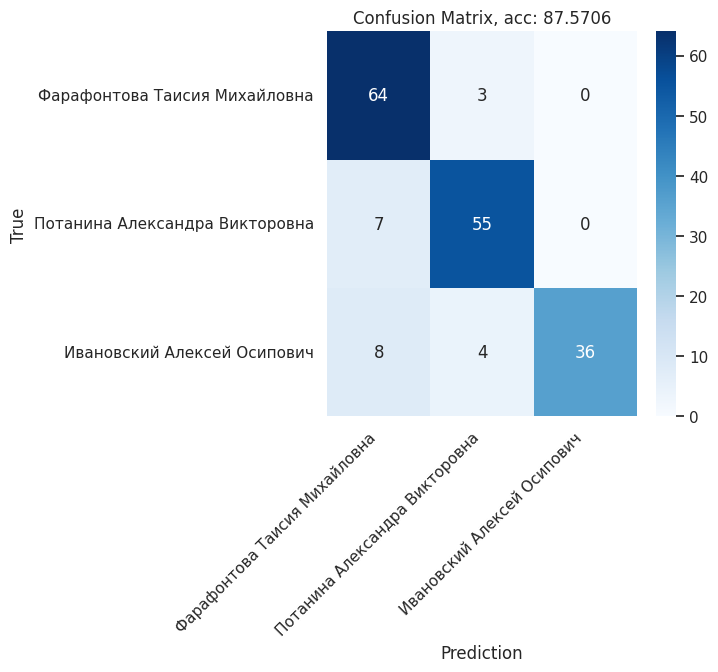

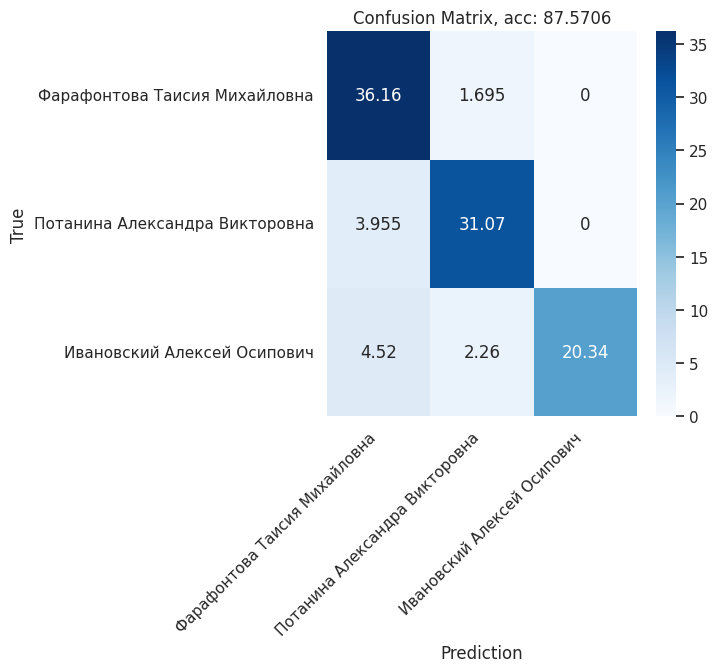

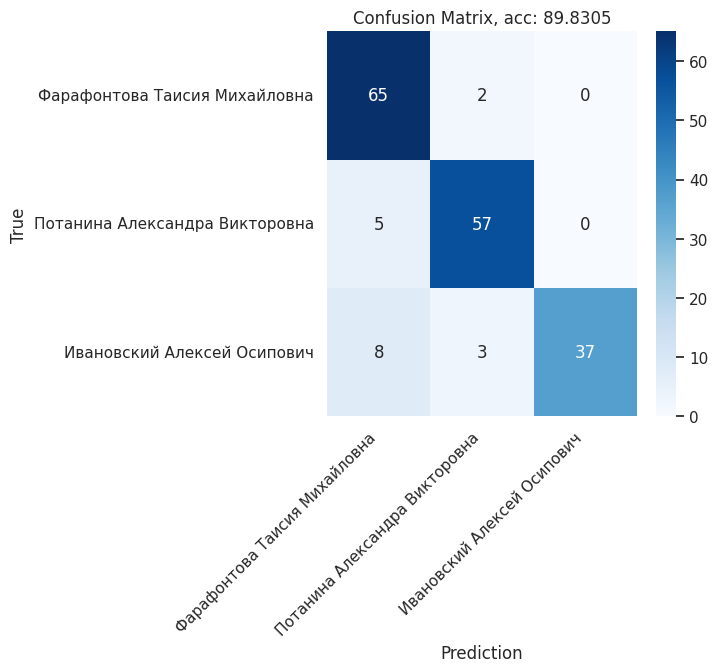

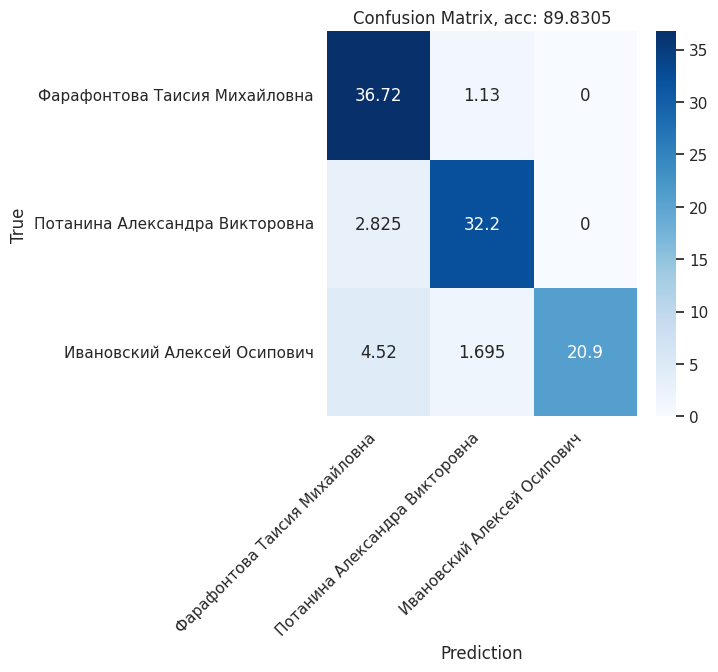

In [ ]:
config = {
    "device" : DEVICE,

    "type" : "window",
    "siam_emb_dim" : 1000,
    "num_not_freeze_layers" : 1,

    "dataset_topk" : 3,
    "folder" : "КККМFOLDER_bin",
    "folder" : "КККМFOLDER_bin",

    "split_percent" : 0.8,
    "balanced" : True,

    "batch_size" : 64,
    "siam_epochs" : 30,
    "cl_epochs" : 20,
}

experiment(config)

### 10 class

Device: cuda
Siam model parameters number: 513000

Dataset length: 410
Фарафонтова Таисия Михайловна   :   67
Потанина Александра Викторовна   :   62
Ивановский Алексей Осипович   :   48
Крутовский Владимир Михайлович   :   46
Свентицкая Мария Хрисанфовна   :   35
Вагнер (Дзвонкевич) Екатерина Николаевна   :   32
Антонова Валентина Константиновна   :   31
Проскурякова Е. Павловна   :   30
Семидалов Вениамин Иванович   :   30
Мендельсон Николай Михайлович   :   29

train dataset: 328, test dataset: 82
--- test_pipeline:
anchor: torch.Size([64, 3, 300, 300])
model:   torch.Size([64, 1000])
--- test_pipeline end
Make logs/2025-04-21 12:18:51 siam_window10


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

00:01:13 epoch:    0, train/val loss = 8.25472 / 8.06553, acc = 65.2439 / 67.07317
00:01:25 epoch:    1, train/val loss = 7.86674 / 7.93258, acc = 67.68293 / 67.07317
00:01:38 epoch:    2, train/val loss = 7.23541 / 7.10414, acc = 73.17073 / 76.82927
00:01:50 epoch:    3, train/val loss = 7.01309 / 7.25848, acc = 70.42683 / 69.5122
00:02:03 epoch:    4, train/val loss = 6.86477 / 6.84827, acc = 71.64634 / 70.73171
00:02:15 epoch:    5, train/val loss = 6.21549 / 7.00006, acc = 74.69512 / 70.73171
00:02:28 epoch:    6, train/val loss = 6.56461 / 7.25030, acc = 71.34146 / 68.29268
00:02:40 epoch:    7, train/val loss = 6.33800 / 6.91778, acc = 72.2561 / 65.85366
00:02:53 epoch:    8, train/val loss = 5.92859 / 6.70911, acc = 74.08537 / 65.85366
00:03:05 epoch:    9, train/val loss = 6.52130 / 6.38125, acc = 68.29268 / 65.85366
00:03:18 epoch:   10, train/val loss = 6.45907 / 6.07562, acc = 70.42683 / 75.60976
00:03:30 epoch:   11, train/val loss = 5.76081 / 7.15840, acc = 78.96341 / 64.6

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

00:00:05 epoch:    0, train/val loss = 1.95169 / 1.76541, acc = 31.09756 / 32.92683
00:00:10 epoch:    1, train/val loss = 1.56230 / 1.44595, acc = 41.76829 / 46.34146
00:00:14 epoch:    2, train/val loss = 1.46113 / 1.28273, acc = 49.39024 / 42.68293
00:00:20 epoch:    3, train/val loss = 1.33197 / 1.24265, acc = 52.7439 / 51.21951
00:00:25 epoch:    4, train/val loss = 1.28497 / 1.15880, acc = 53.96341 / 60.97561
00:00:29 epoch:    5, train/val loss = 1.13244 / 1.15189, acc = 57.92683 / 50.0
00:00:34 epoch:    6, train/val loss = 1.08442 / 1.16230, acc = 59.14634 / 59.7561
00:00:39 epoch:    7, train/val loss = 1.06079 / 1.19546, acc = 63.10976 / 58.53659
00:00:44 epoch:    8, train/val loss = 0.96625 / 1.07708, acc = 64.02439 / 59.7561
00:00:49 epoch:    9, train/val loss = 1.04792 / 1.06703, acc = 61.28049 / 57.31707
00:00:53 epoch:   10, train/val loss = 1.09565 / 1.07864, acc = 63.71951 / 64.63415
00:00:59 epoch:   11, train/val loss = 0.93595 / 0.96111, acc = 67.07317 / 60.97561

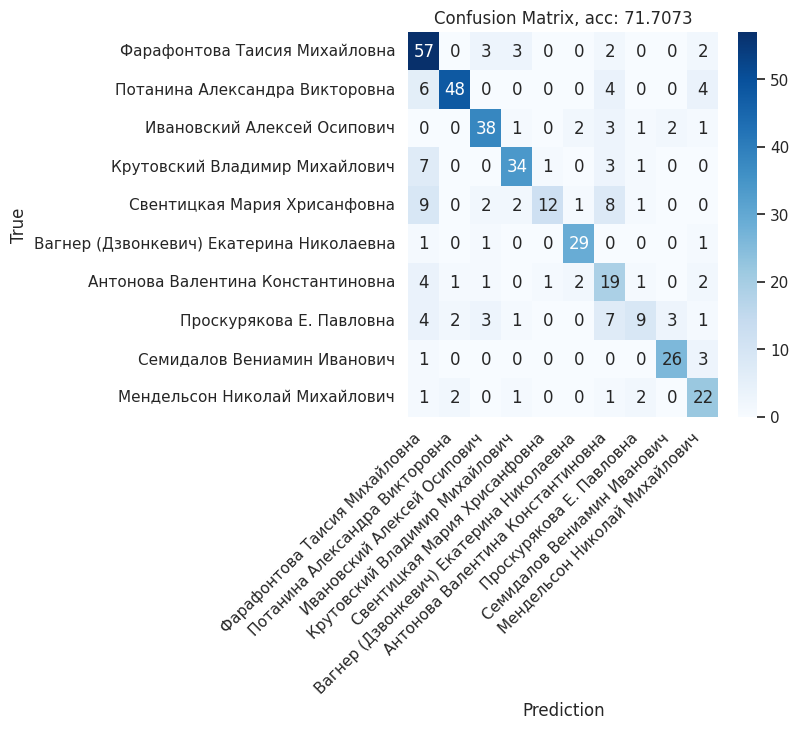

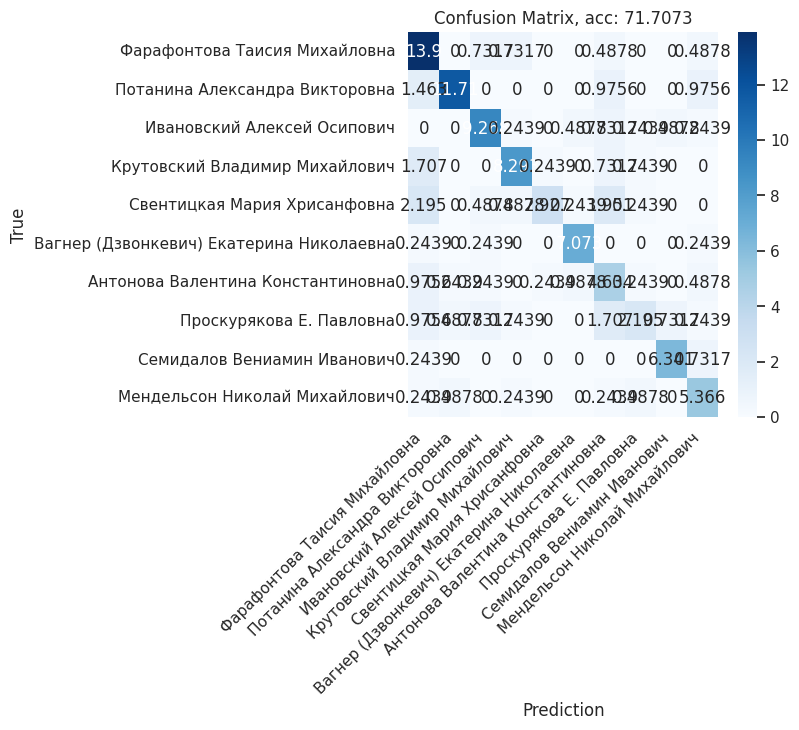

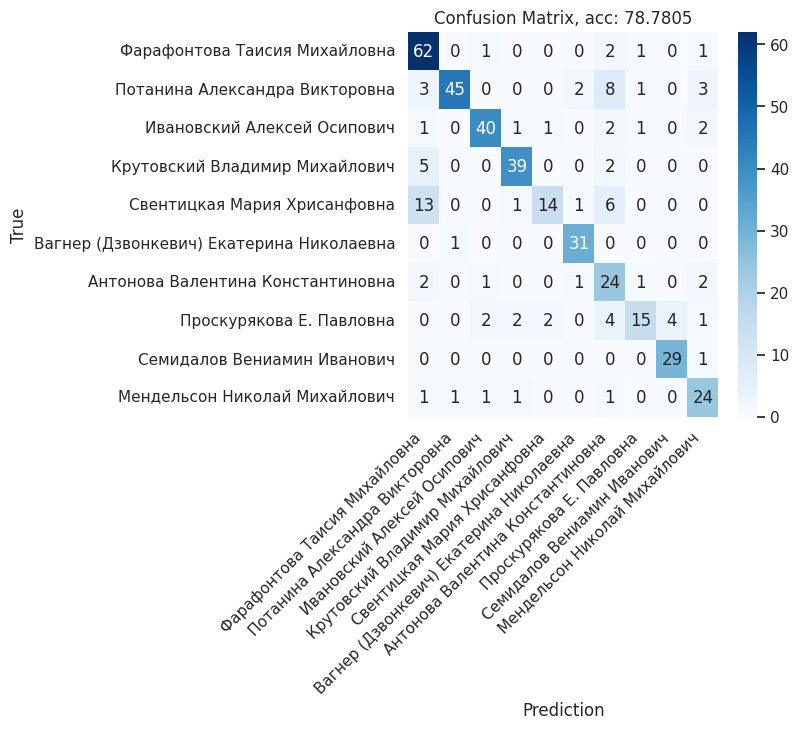

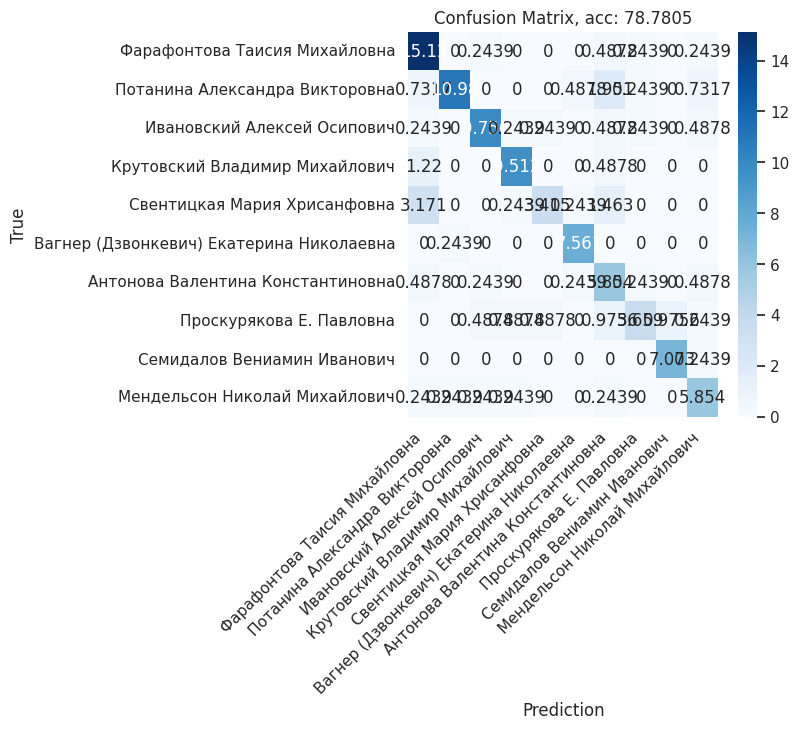

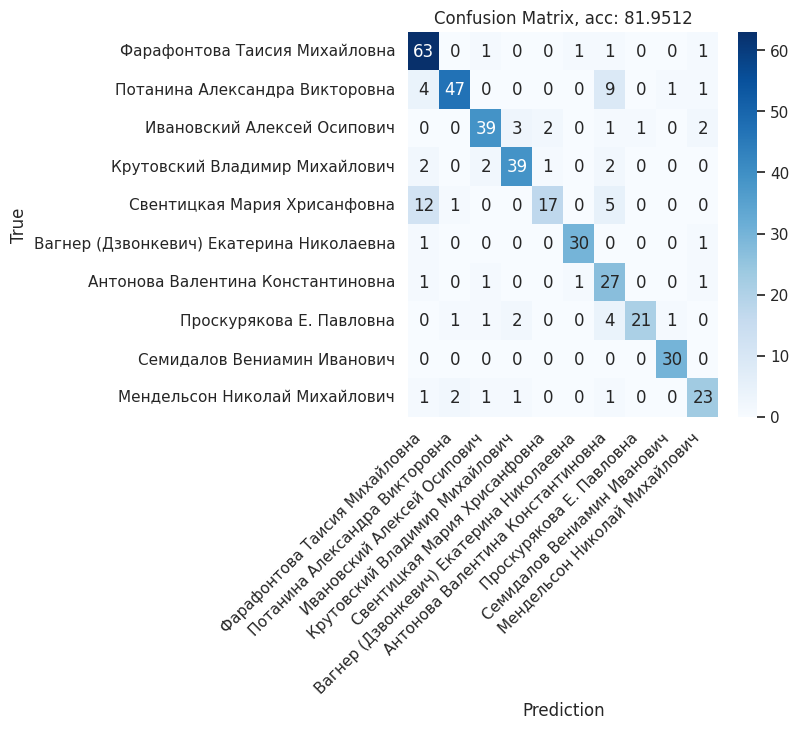

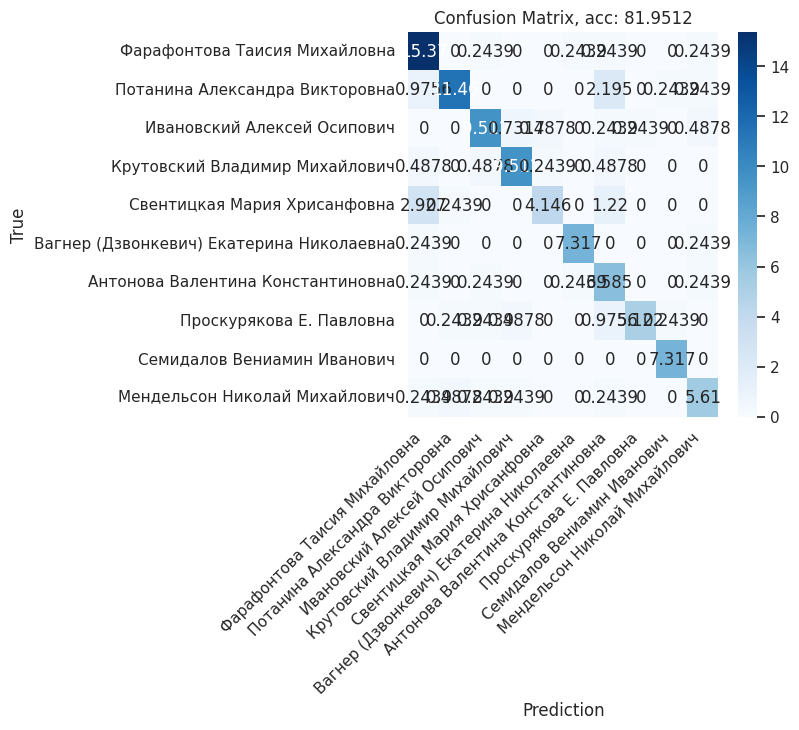

In [ ]:
config = {
    "device" : DEVICE,

    "type" : "window",
    "siam_emb_dim" : 1000,
    "num_not_freeze_layers" : 1,

    "dataset_topk" : 10,
    "folder" : "КККМFOLDER_bin",

    "split_percent" : 0.8,
    "balanced" : False,

    "batch_size" : 64,
    "siam_epochs" : 30,
    "cl_epochs" : 20,
}

experiment(config)

Device: cuda
Siam model parameters number: 513000

train dataset
Фарафонтова Таисия Михайловна   :   53
Потанина Александра Викторовна   :   49
Ивановский Алексей Осипович   :   38
Крутовский Владимир Михайлович   :   36
Свентицкая Мария Хрисанфовна   :   28
Вагнер (Дзвонкевич) Екатерина Николаевна   :   25
Антонова Валентина Константиновна   :   24
Проскурякова Е. Павловна   :   24
Семидалов Вениамин Иванович   :   24
Мендельсон Николай Михайлович   :   23

test dataset
Фарафонтова Таисия Михайловна   :   14
Потанина Александра Викторовна   :   13
Ивановский Алексей Осипович   :   10
Крутовский Владимир Михайлович   :   10
Свентицкая Мария Хрисанфовна   :   7
Вагнер (Дзвонкевич) Екатерина Николаевна   :   7
Антонова Валентина Константиновна   :   7
Проскурякова Е. Павловна   :   6
Семидалов Вениамин Иванович   :   6
Мендельсон Николай Михайлович   :   6

train dataset: 324, test dataset: 86
--- test_pipeline:
anchor: torch.Size([64, 3, 300, 300])
model:   torch.Size([64,

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

00:00:12 epoch:    0, train/val loss = 7.89293 / 7.59942, acc = 70.67901 / 67.44186
00:00:25 epoch:    1, train/val loss = 7.42968 / 7.18144, acc = 64.81481 / 72.09302
00:00:37 epoch:    2, train/val loss = 7.88707 / 6.72011, acc = 68.20988 / 74.4186
00:00:50 epoch:    3, train/val loss = 7.30379 / 7.57027, acc = 68.20988 / 69.76744
00:01:02 epoch:    4, train/val loss = 7.33718 / 6.82564, acc = 69.75309 / 63.95349
00:01:15 epoch:    5, train/val loss = 6.10689 / 5.90919, acc = 74.38272 / 73.25581
00:01:28 epoch:    6, train/val loss = 6.76892 / 6.17923, acc = 66.04938 / 76.74419
00:01:40 epoch:    7, train/val loss = 6.68325 / 6.89896, acc = 69.44444 / 69.76744
00:01:53 epoch:    8, train/val loss = 6.91965 / 4.50932, acc = 67.59259 / 86.04651
00:02:05 epoch:    9, train/val loss = 7.16765 / 5.83173, acc = 74.69136 / 72.09302
00:02:17 epoch:   10, train/val loss = 7.30402 / 7.55692, acc = 69.1358 / 54.65116
00:02:30 epoch:   11, train/val loss = 6.52415 / 5.87699, acc = 72.53086 / 70.

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

00:00:04 epoch:    0, train/val loss = 2.10679 / 2.01635, acc = 20.67901 / 31.39535
00:00:09 epoch:    1, train/val loss = 1.90698 / 1.98764, acc = 37.03704 / 22.09302
00:00:14 epoch:    2, train/val loss = 1.74427 / 1.89717, acc = 33.64198 / 39.53488
00:00:19 epoch:    3, train/val loss = 1.64352 / 1.64478, acc = 43.82716 / 56.97674
00:00:24 epoch:    4, train/val loss = 1.60033 / 1.56168, acc = 45.67901 / 51.16279
00:00:29 epoch:    5, train/val loss = 1.44001 / 1.74516, acc = 53.7037 / 51.16279
00:00:33 epoch:    6, train/val loss = 1.28061 / 1.53082, acc = 56.79012 / 54.65116
00:00:39 epoch:    7, train/val loss = 1.42102 / 1.49036, acc = 52.16049 / 54.65116
00:00:44 epoch:    8, train/val loss = 1.28544 / 1.23705, acc = 56.48148 / 61.62791
00:00:49 epoch:    9, train/val loss = 1.24508 / 1.27525, acc = 56.17284 / 59.30233
00:00:54 epoch:   10, train/val loss = 1.22547 / 1.62400, acc = 57.71605 / 47.67442
00:00:58 epoch:   11, train/val loss = 1.24521 / 1.33185, acc = 55.8642 / 56.

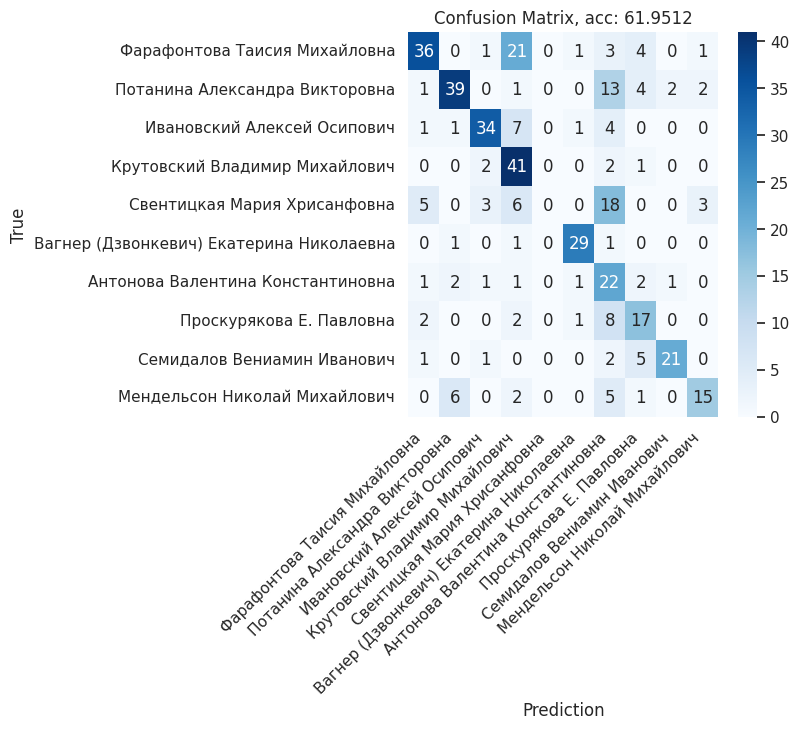

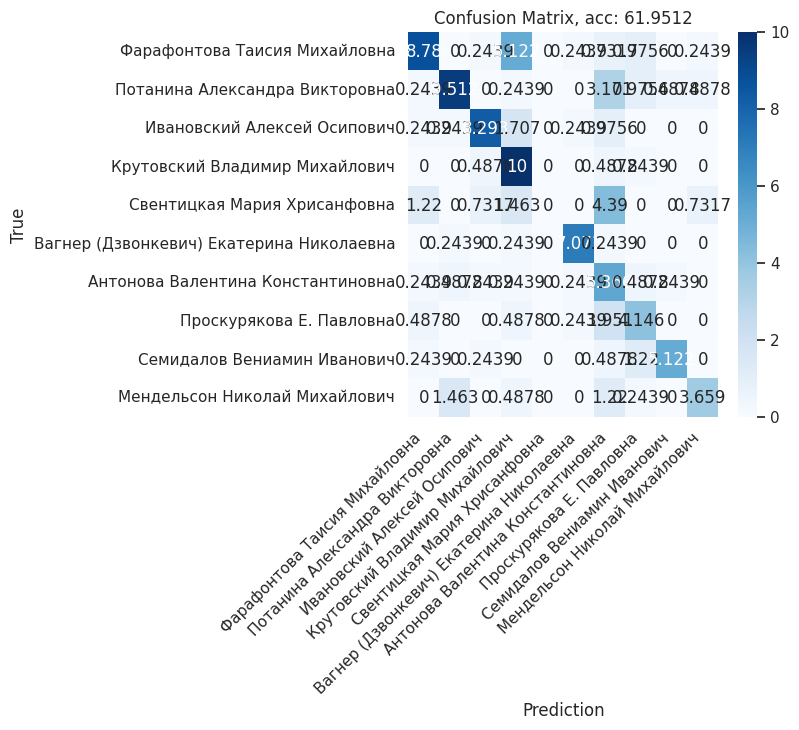

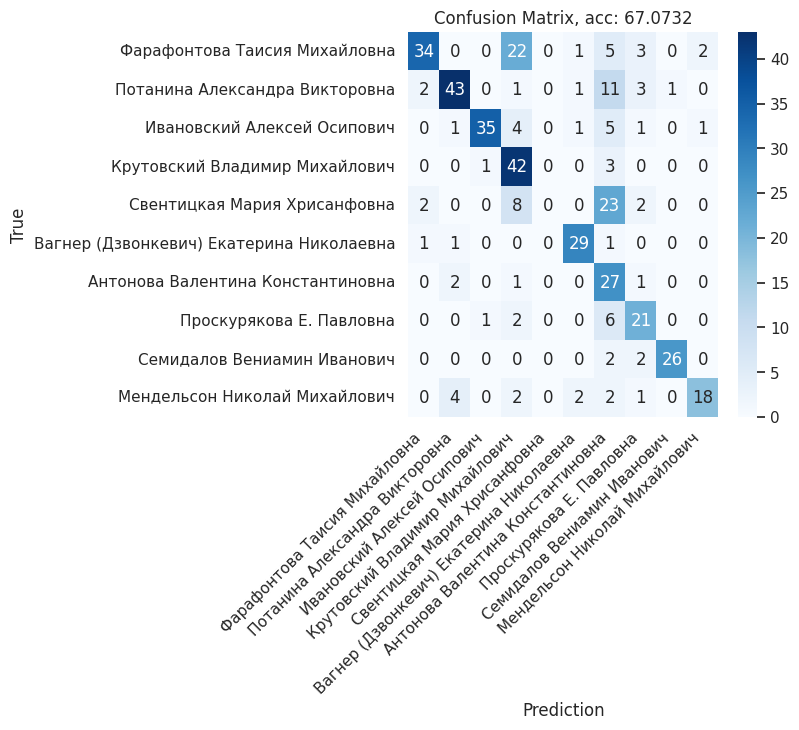

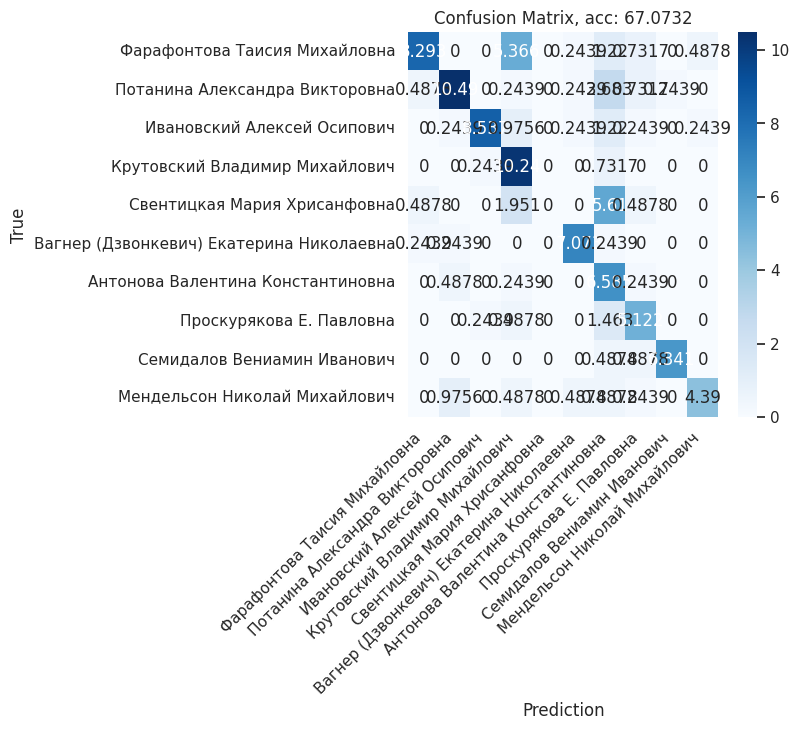

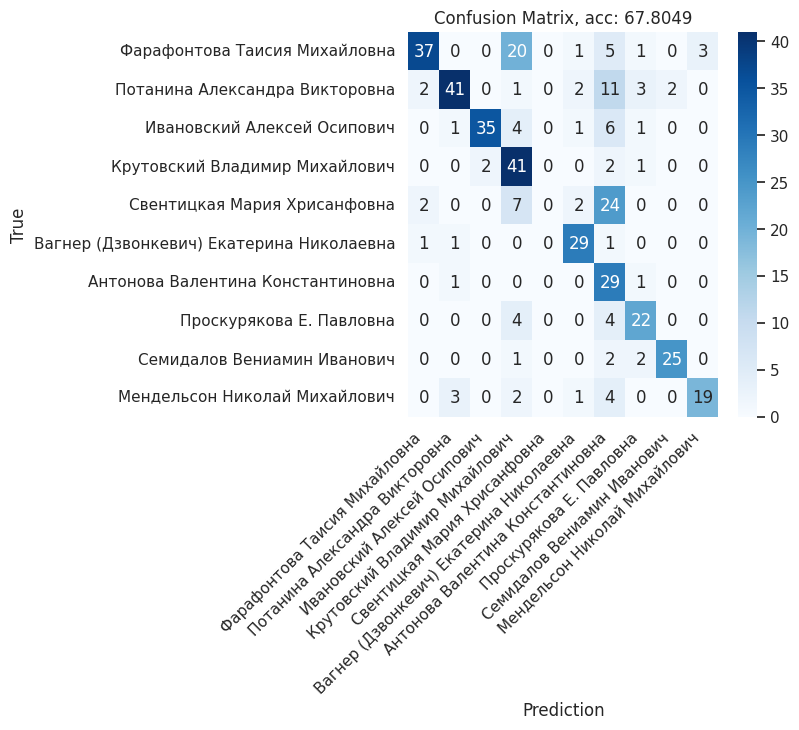

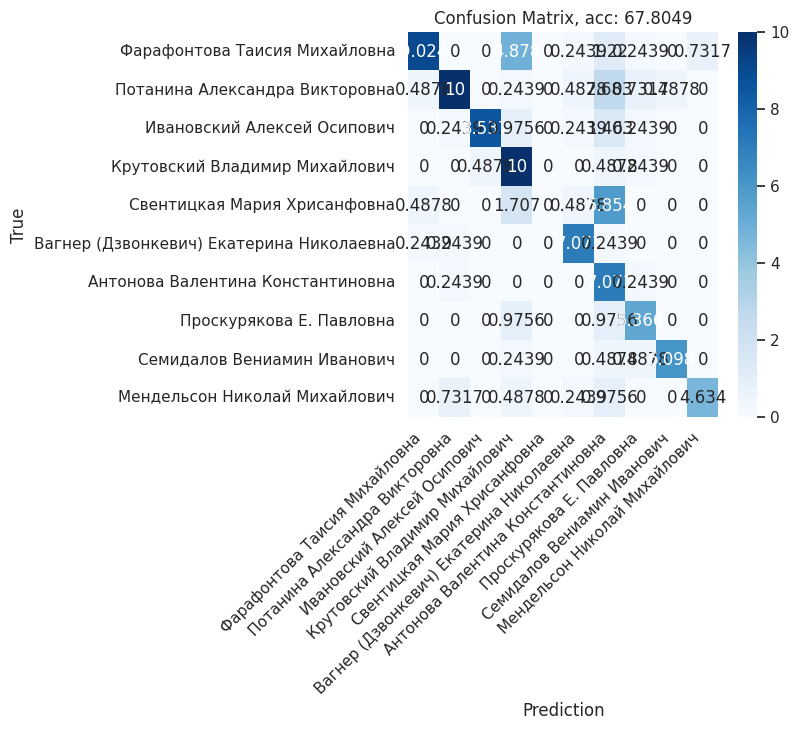

In [ ]:
config = {
    "device" : DEVICE,

    "type" : "window",
    "siam_emb_dim" : 1000,
    "num_not_freeze_layers" : 1,

    "dataset_topk" : 10,
    "folder" : "КККМFOLDER_bin",

    "split_percent" : 0.8,
    "balanced" : True,

    "batch_size" : 64,
    "siam_epochs" : 30,
    "cl_epochs" : 20,
}

experiment(config)

### 20 class

In [ ]:
config = {
    "device" : DEVICE,

    "type" : "window",
    "siam_emb_dim" : 1000,
    "num_not_freeze_layers" : 1,

    "dataset_topk" : 20,
    "folder" : "КККМFOLDER_bin",

    "split_percent" : 0.8,
    "balanced" : False,

    "batch_size" : 64,
    "siam_epochs" : 30,
    "cl_epochs" : 20,
}

experiment(config)

In [ ]:
config = {
    "device" : DEVICE,

    "type" : "window",
    "siam_emb_dim" : 1000,
    "num_not_freeze_layers" : 1,

    "dataset_topk" : 20,
    "folder" : "КККМFOLDER_bin",

    "split_percent" : 0.8,
    "balanced" : True,

    "batch_size" : 64,
    "siam_epochs" : 30,
    "cl_epochs" : 20,
}

experiment(config)

### 100 class

Device: cuda
Siam model parameters number: 513000

Dataset length: 1384
Фарафонтова Таисия Михайловна   :   67
Потанина Александра Викторовна   :   62
Ивановский Алексей Осипович   :   48
Крутовский Владимир Михайлович   :   46
Свентицкая Мария Хрисанфовна   :   35
Вагнер (Дзвонкевич) Екатерина Николаевна   :   32
Антонова Валентина Константиновна   :   31
Проскурякова Е. Павловна   :   30
Семидалов Вениамин Иванович   :   30
Мендельсон Николай Михайлович   :   29
Крутовская Лидия Симоновна   :   29
Ржавская Надежда Федоровна   :   28
Попов Иван Иванович   :   25
Серошевский Вацлав Леопольдович   :   25
Адрианов Александр Васильевич   :   23
Анучин Дмитрий Николаевич   :   22
Козьмин Николай Николаевич   :   21
Пантелеев Лонгин Федорович   :   19
Руднев Андрей Дмитриевич   :   19
Гуркин Григорий Иванович   :   18
Лаврский Валериан Викторович   :   17
Тиблен Н.   :   16
Красноженова Мария Васильевна   :   16
Тихонравова Раиса   :   15
Сибирякова Анна Михайловна   :   15
Фе

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

00:00:40 epoch:    0, train/val loss = 7.68951 / 7.50454, acc = 69.19603 / 71.48014
00:01:20 epoch:    1, train/val loss = 6.94116 / 6.66701, acc = 71.72538 / 74.36823
00:02:00 epoch:    2, train/val loss = 6.34090 / 6.82700, acc = 72.99006 / 68.59206
00:02:40 epoch:    3, train/val loss = 6.22384 / 5.97344, acc = 71.45438 / 72.56318
00:03:20 epoch:    4, train/val loss = 5.58067 / 5.58250, acc = 75.79042 / 76.5343
00:04:00 epoch:    5, train/val loss = 5.49981 / 5.42042, acc = 74.97742 / 75.09025
00:04:40 epoch:    6, train/val loss = 5.34723 / 5.53271, acc = 75.60976 / 73.2852
00:05:21 epoch:    7, train/val loss = 5.36632 / 5.32582, acc = 73.71274 / 75.09025
00:06:01 epoch:    8, train/val loss = 5.24680 / 5.32656, acc = 76.15176 / 74.36823
00:06:42 epoch:    9, train/val loss = 5.04940 / 5.28629, acc = 75.70009 / 75.45126
00:07:22 epoch:   10, train/val loss = 5.08566 / 4.90517, acc = 77.41644 / 76.5343
00:08:02 epoch:   11, train/val loss = 4.84381 / 5.09003, acc = 77.32611 / 76.5

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

00:00:16 epoch:    0, train/val loss = 4.18954 / 3.86773, acc = 10.47877 / 13.71841
00:00:32 epoch:    1, train/val loss = 3.60734 / 3.61661, acc = 19.87353 / 17.68953
00:00:48 epoch:    2, train/val loss = 3.24855 / 3.32876, acc = 26.3776 / 24.54874
00:01:05 epoch:    3, train/val loss = 3.01287 / 3.11372, acc = 29.08762 / 26.7148
00:01:21 epoch:    4, train/val loss = 2.89734 / 3.15308, acc = 32.06865 / 28.88087
00:01:38 epoch:    5, train/val loss = 2.78750 / 3.01376, acc = 32.33966 / 26.35379
00:01:54 epoch:    6, train/val loss = 2.70678 / 2.96426, acc = 34.68835 / 27.79783
00:02:11 epoch:    7, train/val loss = 2.61734 / 2.99762, acc = 34.77868 / 26.35379
00:02:27 epoch:    8, train/val loss = 2.56234 / 2.90982, acc = 36.04336 / 30.68592
00:02:43 epoch:    9, train/val loss = 2.47147 / 2.91360, acc = 38.30172 / 31.40794
00:02:59 epoch:   10, train/val loss = 2.43212 / 2.90631, acc = 37.94038 / 30.32491
00:03:16 epoch:   11, train/val loss = 2.48848 / 2.91649, acc = 37.75971 / 31.

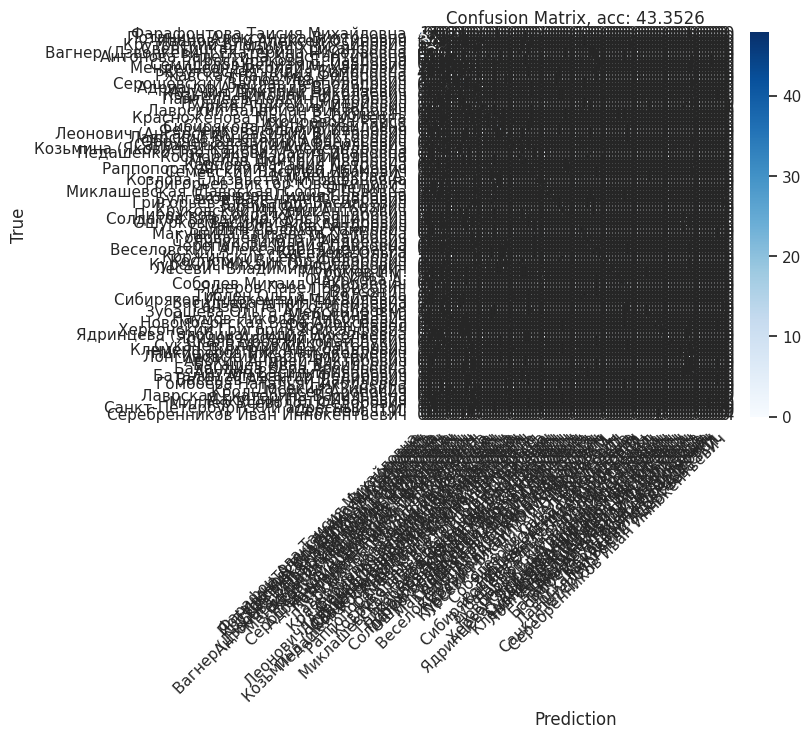

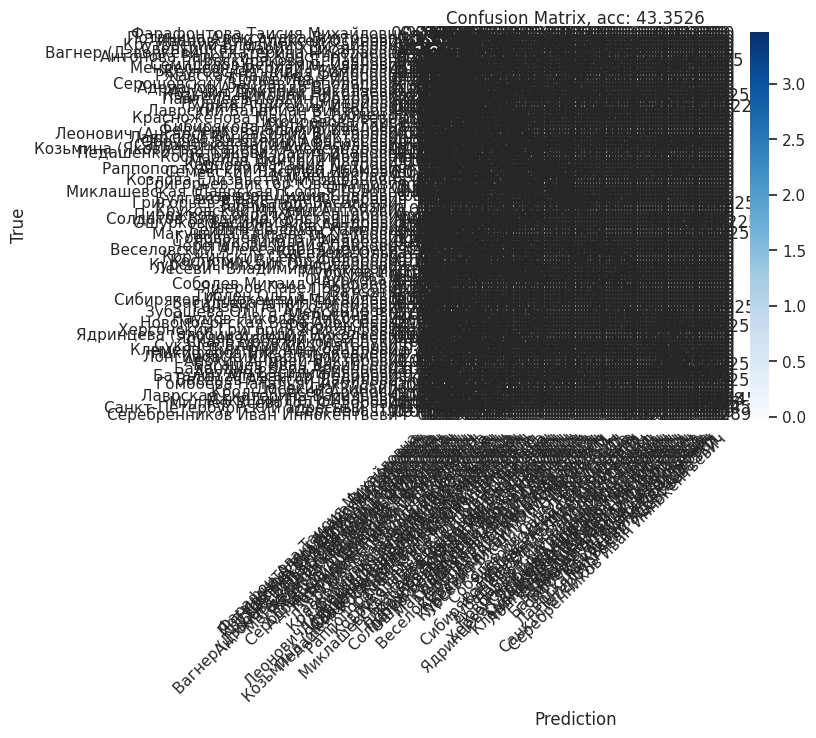

OutOfMemoryError: CUDA out of memory. Tried to allocate 6.96 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.37 GiB is free. Process 32368 has 13.37 GiB memory in use. Of the allocated memory 7.27 GiB is allocated by PyTorch, and 5.97 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
config = {
    "device" : DEVICE,

    "type" : "window",
    "siam_emb_dim" : 1000,
    "num_not_freeze_layers" : 1,

    "dataset_topk" : 100,
    "folder" : "КККМFOLDER_bin",

    "split_percent" : 0.8,
    "balanced" : False,

    "batch_size" : 64,
    "siam_epochs" : 30,
    "cl_epochs" : 20,
}

experiment(config)

In [ ]:
config = {
    "device" : DEVICE,

    "type" : "window",
    "siam_emb_dim" : 1000,
    "num_not_freeze_layers" : 1,

    "dataset_topk" : 100,
    "folder" : "КККМFOLDER_bin",

    "split_percent" : 0.8,
    "balanced" : True,

    "batch_size" : 64,
    "siam_epochs" : 30,
    "cl_epochs" : 20,
}

experiment(config)

## Strokes

In [18]:
def experiment_strokes(config):
    print(f'Device: {config["device"]}')

    model = NetworkStrokes(output_emb=config["siam_emb_dim"]).to(config["device"])

    print(f"Siam model parameters number: {number_of_parameters(model)}")

    transform = transforms.Compose(
    [
            transforms.ToTensor(),
            Min_size(50),
    ])

    if not config["balanced"]:
        dataset = My_TripletFolder(config["folder"], transform=transform, topk=config["dataset_topk"])
        print(f"\nDataset length: {len(dataset)}")
        for key, value in dataset.dir2count.items():
            print(f"{key}   :   {value}")
        print()

        train_dataset, test_dataset = split_dataset(dataset, percent=config["split_percent"])
        print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")
    else:
        train_dataset, test_dataset = My_Balanced_split_dataset(config["folder"], transform=transform, topk=config["dataset_topk"],
                                                                percent=config["split_percent"], type="siam")

        print("\ntrain dataset")
        for key, value in train_dataset.dir2count.items():
            print(f"{key}   :   {value}")
        print()

        print("test dataset")
        for key, value in test_dataset.dir2count.items():
            print(f"{key}   :   {value}")
        print()

        print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")

    test_pipeline(model, train_dataset, device=config["device"], batch_size=config["batch_size"], collate_fn = pad_collate_siam, type = "siam")

    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    criterion = torch.nn.TripletMarginLoss(margin=9, p=2)

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, collate_fn=pad_collate_siam)
    val_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, collate_fn=pad_collate_siam)

    x = '_balanced' if config["balanced"] else ""
    trainer = Trainer(model, optimizer, criterion, type = "siam", name = f'siam_{config["type"]}{config["dataset_topk"]}{x}', device=config["device"])
    dir = trainer.train(train_loader, val_loader, n_epochs = config["siam_epochs"])
    # end siam train

    model = load_best_model(model, dir=dir)
    print(f"train/val acc : {evaluation_siam(model, train_loader)} / {evaluation_siam(model, val_loader)}")

    model.eval()
    for p in model.parameters():
        p.requires_grad = False
    print(f"Siam model parameters number: {number_of_parameters(model)}")

    # start cl train
    cl_model = nn.Sequential(nn.Linear(config["siam_emb_dim"], 512), nn.ReLU(), nn.Linear(512, config["dataset_topk"])).to(DEVICE)
    print(f"Class model parameters number: {number_of_parameters(cl_model)}")

    transform = transforms.Compose(
    [
            transforms.ToTensor(),
            Min_size(50),
            ToModel(model, DEVICE),
    ])

    if not config["balanced"]:
        dataset = My_Folder(config["folder"], transform, topk=config["dataset_topk"])
        print(f"Dataset length: {len(dataset)}")
        train_dataset, test_dataset = split_dataset(dataset, percent=config["split_percent"])
        print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}\n")
    else:
        train_dataset, test_dataset = My_Balanced_split_dataset(config["folder"], transform=transform, topk=config["dataset_topk"],
                                                                percent=config["split_percent"], type="not siam")
        print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")

    test_pipeline(cl_model, train_dataset, device=config["device"], batch_size=config["batch_size"], type = "not siam")

    optimizer = torch.optim.Adam(cl_model.parameters(), lr=3e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

    trainer = Trainer(cl_model, optimizer, criterion, type = "not siam", name = f'cl_{config["type"]}{config["dataset_topk"]}{x}', device=config["device"])
    dir = trainer.train(train_loader, val_loader, n_epochs = config["cl_epochs"])

    cl_model.eval()
    for p in cl_model.parameters():
        p.requires_grad = False
    print(f"Class model parameters number: {number_of_parameters(cl_model)}")
    # end cl train

    # ensemble
    model_all = Pipeline(model, cl_model).to(config["device"])
    print(f"Model parameters number: {number_of_parameters(model_all)}")

    transform = transforms.Compose(
    [
            transforms.ToTensor(),
            Min_size(50),
    ])

    dataset = My_Folder(config["folder"], transform, topk=config["dataset_topk"])

    ensemble_strokes(model_all, pad_collate, dataset, config, dir)

In [19]:
PAD_ID = -1

def pad_collate(batch):
    # BATCH_SIZE * C * EMB_SIZE x SEQ_LEN
    list_tensors, list_targets = zip(*batch)
    # print(len(list_tersors), len(list_targets))
    # print(list_tersors[0].shape)
    ans = [None] * len(list_tensors)
    # tokens_len = [None] * len(list_tersors)
    # masks = [None] * len(list_tersors)

    for i in range(len(list_tensors)):
        # tokens_len[i] = list_tensors[i].shape[-1] # SEQ_LEN
        ans[i] = list_tensors[i].permute(2, 0, 1) # C x EMB_SIZE x SEQ_LEN -> SEQ_LEN x C x EMB_SIZE

    # BATCH_SIZE * SEQ_LEN * C * EMB_SIZE ->
    # -> BATCH_SIZE x C x EMB_SIZE x SEQ_LEN
    return pad_sequence(ans, batch_first=True, padding_value=PAD_ID).permute(0, 2, 3, 1), torch.tensor(list_targets)


def pad(ans):
    return pad_sequence(ans, batch_first=True, padding_value=PAD_ID).permute(0, 2, 3, 1)

def pad_collate_siam(batch):
    # BATCH_SIZE * C * EMB_SIZE x SEQ_LEN
    list_tensors1, list_tensors2, list_tensors3 = zip(*batch)
    batch_size = len(list_tensors1)
    list_tensors = list_tensors1 + list_tensors2 + list_tensors3

    ans = [None] * len(list_tensors)
    # tokens_len = [None] * len(list_tersors)
    # masks = [None] * len(list_tersors)

    for i in range(len(list_tensors)):
        # tokens_len[i] = list_tensors[i].shape[-1] # SEQ_LEN
        ans[i] = list_tensors[i].permute(2, 0, 1) # C x EMB_SIZE x SEQ_LEN -> SEQ_LEN x C x EMB_SIZE

    # BATCH_SIZE * SEQ_LEN * C * EMB_SIZE ->
    # -> BATCH_SIZE x C x EMB_SIZE x SEQ_LEN

    ans1, ans2, ans3 = ans[:batch_size], ans[batch_size : 2 * batch_size], ans[2 * batch_size:]
    return pad(ans1), pad(ans2), pad(ans3)


class NetworkStrokes(nn.Module):
    def __init__(self, in_channels=3, out_channels=10, emb_size=18, hid_size=128, output_emb = 1000, num_layers=1):
        super().__init__()
        self.CNN = nn.Sequential(
                     nn.Conv2d(in_channels=in_channels, out_channels=3, kernel_size=3),
                     nn.BatchNorm2d(3),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2, stride=(2, 3)),

                     nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3),
                     nn.BatchNorm2d(5),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2, stride=(1, 3)),

                     nn.Conv2d(in_channels=5, out_channels=out_channels, kernel_size=3),
                     nn.BatchNorm2d(10),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2, stride=(1, 2)),
                     )

        self.linear = nn.Linear(out_channels, 1)

        self.LSTM = nn.LSTM(input_size=emb_size, # emb_size зависит от CNN
                            hidden_size=hid_size,
                            num_layers=num_layers,
                            batch_first=True)

        self.classifier = nn.Sequential(nn.Linear(hid_size, output_emb))

    def forward(self, x):
        # x ~ BATCH_SIZE x C x EMB_SIZE x SEQ_LEN
        # tokens_lens ~ BATCH_SIZE
        mask = (x != PAD_ID).int()
        # print(x.shape, mask.shape)
        # print(1, x.shape)
        x = self.CNN(x) # BATCH_SIZE x out_channels x EMB_SIZE_new x SEQ_LEN_new
        # print(2, x.shape)
        x = x.permute(0, 2, 3, 1) # BATCH_SIZE x EMB_SIZE_new x SEQ_LEN_new x out_channels
        x = self.linear(x).squeeze(dim=-1) # BATCH_SIZE x EMB_SIZE_new x SEQ_LEN_new
        x = x.permute(0, 2, 1) # BATCH_SIZE x SEQ_LEN_new x EMB_SIZE_new


        mask = mask[:, 0, 0, ::18] # BATCH_SIZE x SEQ_LEN_new
        mask = mask[:, :x.shape[1]]

        # print(3, x.shape)
        x, _ = self.LSTM(x) # BATCH_SIZE x SEQ_LEN_new x HIDDEN_SIZE

        # print(x.shape, mask.shape)
        x = x * mask[..., None] # BATCH_SIZE x SEQ_LEN_new x HIDDEN_SIZE

        sum = x.sum(dim = 1) # BATCH_SIZE x HIDDEN_SIZE
        col = mask.sum(dim = 1) # BATCH_SIZE

        x = sum / col[..., None]
        # x = x.mean(dim = 1)
        # last_hid_idxs = (tokens_lens / 18).to(int) - 1
        # last_hid_idxs = (tokens_lens / 18).to(int) - 5
        # x = x[torch.arange(len(tokens_lens)), last_hid_idxs - 1, :] # BATCH_SIZE x HIDDEN_SIZE
        # BATCH_SIZE x HIDDEN_SIZE
        return self.classifier(x)

### 3 class

In [20]:
config = {
    "device" : DEVICE,

    "type" : "strokes",
    "siam_emb_dim" : 1000,

    "dataset_topk" : 3,
    "folder" : "КККМFOLDER_strokes_bin_ok",

    "split_percent" : 0.8,
    "balanced" : False,

    "batch_size" : 64,
    "siam_epochs" : 30,
    "cl_epochs" : 20,
}

experiment_strokes(config)

Device: cuda
Siam model parameters number: 205507

Dataset length: 2865
Потанина Александра Викторовна   :   1384
Фарафонтова Таисия Михайловна   :   775
Вагнер (Дзвонкевич) Екатерина Николаевна   :   706

train dataset: 2292, test dataset: 573
--- test_pipeline:
anchor: torch.Size([64, 3, 50, 1121])
model:   torch.Size([64, 1000])
--- test_pipeline end
Make logs/2025-04-21 14:32:05 siam_strokes3


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

00:00:36 epoch:    0, train/val loss = 8.11655 / 6.39436, acc = 66.05585 / 67.71379
00:01:12 epoch:    1, train/val loss = 5.58743 / 5.92492, acc = 73.21117 / 69.80803
00:01:47 epoch:    2, train/val loss = 5.32311 / 5.26490, acc = 74.43281 / 74.86911
00:02:21 epoch:    3, train/val loss = 5.21758 / 5.05332, acc = 74.95637 / 74.69459
00:02:57 epoch:    4, train/val loss = 4.75003 / 5.09870, acc = 77.6178 / 75.04363
00:03:32 epoch:    5, train/val loss = 4.71281 / 4.65077, acc = 77.35602 / 77.66143
00:04:06 epoch:    6, train/val loss = 4.44934 / 3.99662, acc = 79.23211 / 81.15183
00:04:41 epoch:    7, train/val loss = 4.14484 / 4.17184, acc = 81.15183 / 80.45375
00:05:16 epoch:    8, train/val loss = 3.62648 / 3.51573, acc = 82.89703 / 84.11867
00:05:51 epoch:    9, train/val loss = 3.75558 / 4.13908, acc = 83.46422 / 80.80279
00:06:25 epoch:   10, train/val loss = 3.53181 / 3.40560, acc = 83.42059 / 84.99127
00:07:00 epoch:   11, train/val loss = 3.30715 / 2.98512, acc = 84.86038 / 86

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

00:00:15 epoch:    0, train/val loss = 0.41487 / 0.19938, acc = 85.82024 / 94.7644
00:00:29 epoch:    1, train/val loss = 0.22134 / 0.17939, acc = 92.75742 / 94.24084
00:00:44 epoch:    2, train/val loss = 0.22008 / 0.17935, acc = 92.93194 / 93.71728
00:00:59 epoch:    3, train/val loss = 0.21490 / 0.17657, acc = 92.67016 / 93.54276
00:01:13 epoch:    4, train/val loss = 0.21454 / 0.16841, acc = 92.71379 / 94.41536
00:01:28 epoch:    5, train/val loss = 0.20863 / 0.21913, acc = 92.45201 / 92.84468
00:01:42 epoch:    6, train/val loss = 0.21340 / 0.17390, acc = 92.88831 / 93.71728
00:01:57 epoch:    7, train/val loss = 0.20160 / 0.16318, acc = 92.97557 / 94.7644
00:02:12 epoch:    8, train/val loss = 0.20314 / 0.16329, acc = 92.97557 / 94.58988
00:02:26 epoch:    9, train/val loss = 0.20712 / 0.16961, acc = 93.15009 / 93.8918
00:02:41 epoch:   10, train/val loss = 0.19814 / 0.16643, acc = 93.36824 / 94.58988
00:02:56 epoch:   11, train/val loss = 0.20358 / 0.16667, acc = 93.41187 / 94.4

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 702 but got size 778 for tensor number 1 in the list.

In [ ]:
config = {
    "device" : DEVICE,

    "type" : "strokes",
    "siam_emb_dim" : 1000,

    "dataset_topk" : 3,
    "folder" : "КККМFOLDER_strokes_bin_ok",

    "split_percent" : 0.8,
    "balanced" : True,

    "batch_size" : 64,
    "siam_epochs" : 30,
    "cl_epochs" : 20,
}

experiment_strokes(config)

### 10 class

Device: cuda
Siam model parameters number: 205507

Dataset length: 6670
Потанина Александра Викторовна   :   1384
Фарафонтова Таисия Михайловна   :   775
Вагнер (Дзвонкевич) Екатерина Николаевна   :   706
Крутовский Владимир Михайлович   :   678
Ивановский Алексей Осипович   :   664
Антонова Валентина Константиновна   :   544
Семидалов Вениамин Иванович   :   518
Проскурякова Е. Павловна   :   489
Крутовская Лидия Симоновна   :   462
Ржавская Надежда Федоровна   :   450

train dataset: 5336, test dataset: 1334
--- test_pipeline:
anchor: torch.Size([64, 3, 50, 932])
model:   torch.Size([64, 1000])
--- test_pipeline end
Make logs/2025-04-21 14:59:34 siam_strokes10


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

00:01:24 epoch:    0, train/val loss = 8.15374 / 7.33872, acc = 60.7009 / 62.5937
00:02:44 epoch:    1, train/val loss = 7.43509 / 7.25443, acc = 61.71289 / 63.7931
00:04:04 epoch:    2, train/val loss = 7.12388 / 7.11284, acc = 63.36207 / 62.66867
00:05:24 epoch:    3, train/val loss = 7.08428 / 6.93097, acc = 64.48651 / 64.54273
00:06:43 epoch:    4, train/val loss = 6.93465 / 6.83899, acc = 65.32984 / 65.44228
00:08:03 epoch:    5, train/val loss = 6.77082 / 6.79771, acc = 66.54798 / 65.29235
00:09:24 epoch:    6, train/val loss = 6.67774 / 6.21822, acc = 66.54798 / 70.16492
00:10:45 epoch:    7, train/val loss = 6.47404 / 6.76422, acc = 67.54123 / 66.94153
00:12:06 epoch:    8, train/val loss = 6.50641 / 6.49613, acc = 67.52249 / 66.56672
00:13:27 epoch:    9, train/val loss = 6.33646 / 6.16707, acc = 68.44078 / 69.64018
00:14:48 epoch:   10, train/val loss = 6.21143 / 6.01019, acc = 69.34033 / 70.38981
00:16:09 epoch:   11, train/val loss = 6.22491 / 6.13304, acc = 69.6027 / 69.64

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

00:00:34 epoch:    0, train/val loss = 1.40578 / 1.36932, acc = 51.59295 / 53.67316
00:01:08 epoch:    1, train/val loss = 1.30435 / 1.37833, acc = 54.38531 / 52.54873
00:01:42 epoch:    2, train/val loss = 1.28929 / 1.33957, acc = 55.04123 / 53.97301
00:02:16 epoch:    3, train/val loss = 1.27327 / 1.35879, acc = 54.98501 / 53.29835
00:02:49 epoch:    4, train/val loss = 1.26671 / 1.32150, acc = 55.94078 / 54.57271
00:03:23 epoch:    5, train/val loss = 1.26037 / 1.32109, acc = 55.8096 / 53.22339
00:03:56 epoch:    6, train/val loss = 1.25777 / 1.29473, acc = 56.29685 / 55.92204
00:04:30 epoch:    7, train/val loss = 1.23893 / 1.29460, acc = 56.84033 / 56.29685
00:05:04 epoch:    8, train/val loss = 1.22951 / 1.30723, acc = 56.95277 / 54.87256
00:05:37 epoch:    9, train/val loss = 1.22213 / 1.29225, acc = 56.74663 / 55.69715
00:06:11 epoch:   10, train/val loss = 1.21998 / 1.30350, acc = 57.40255 / 54.72264
00:06:44 epoch:   11, train/val loss = 1.21558 / 1.29434, acc = 57.66492 / 55

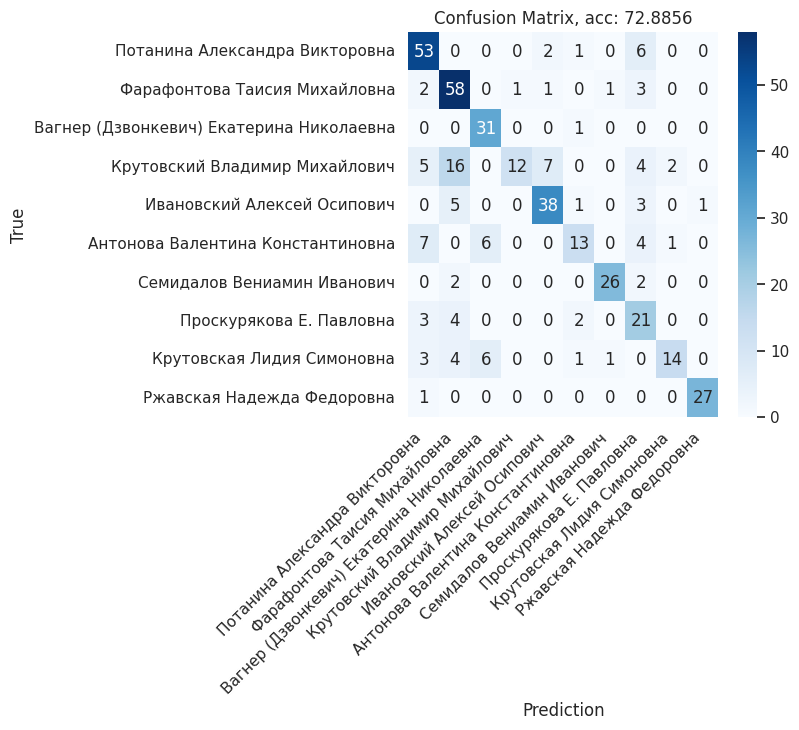

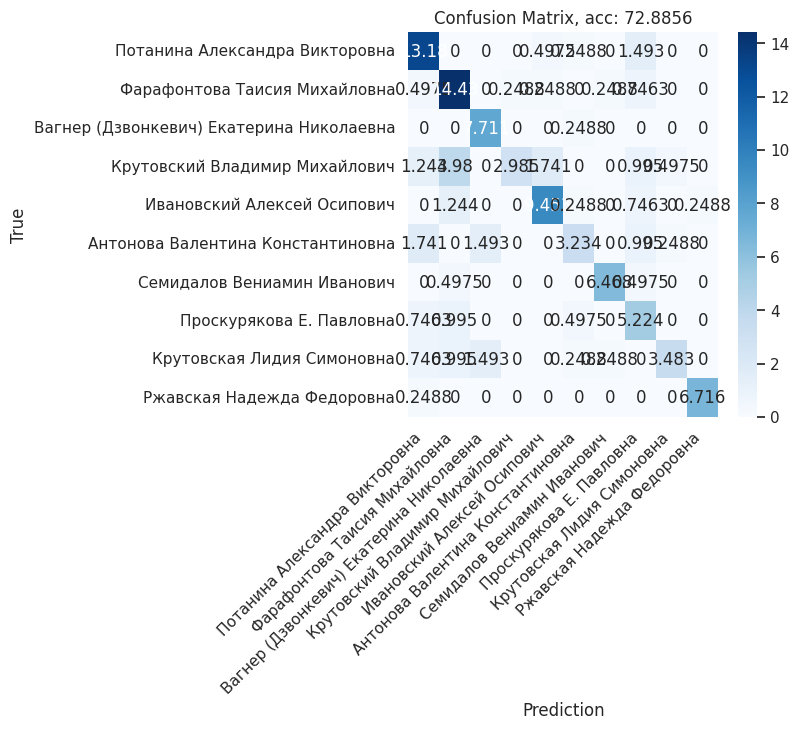

In [36]:
config = {
    "device" : DEVICE,

    "type" : "strokes",
    "siam_emb_dim" : 1000,

    "dataset_topk" : 10,
    "folder" : "КККМFOLDER_strokes_bin_ok",

    "split_percent" : 0.8,
    "balanced" : False,

    "batch_size" : 64,
    "siam_epochs" : 30,
    "cl_epochs" : 20,
}

experiment_strokes(config)

In [ ]:
config = {
    "device" : DEVICE,

    "type" : "strokes",
    "siam_emb_dim" : 1000,

    "dataset_topk" : 10,
    "folder" : "КККМFOLDER_strokes_bin_ok",

    "split_percent" : 0.8,
    "balanced" : True,

    "batch_size" : 64,
    "siam_epochs" : 30,
    "cl_epochs" : 20,
}

experiment_strokes(config)

### 20 class

In [ ]:
config = {
    "device" : DEVICE,

    "type" : "strokes",
    "siam_emb_dim" : 1000,

    "dataset_topk" : 20,
    "folder" : "КККМFOLDER_strokes_bin_ok",

    "split_percent" : 0.8,
    "balanced" : False,

    "batch_size" : 64,
    "siam_epochs" : 30,
    "cl_epochs" : 20,
}

experiment_strokes(config)

In [ ]:
config = {
    "device" : DEVICE,

    "type" : "strokes",
    "siam_emb_dim" : 1000,

    "dataset_topk" : 20,
    "folder" : "КККМFOLDER_strokes_bin_ok",

    "split_percent" : 0.8,
    "balanced" : True,

    "batch_size" : 64,
    "siam_epochs" : 30,
    "cl_epochs" : 20,
}

experiment_strokes(config)

### 100 class

In [ ]:
config = {
    "device" : DEVICE,

    "type" : "strokes",
    "siam_emb_dim" : 1000,

    "dataset_topk" : 100,
    "folder" : "КККМFOLDER_strokes_bin_ok",

    "split_percent" : 0.8,
    "balanced" : False,

    "batch_size" : 64,
    "siam_epochs" : 30,
    "cl_epochs" : 20,
}

experiment_strokes(config)

In [ ]:
config = {
    "device" : DEVICE,

    "type" : "strokes",
    "siam_emb_dim" : 1000,

    "dataset_topk" : 100,
    "folder" : "КККМFOLDER_strokes_bin_ok",

    "split_percent" : 0.8,
    "balanced" : True,

    "batch_size" : 64,
    "siam_epochs" : 30,
    "cl_epochs" : 20,
}

experiment_strokes(config)

# ensemble

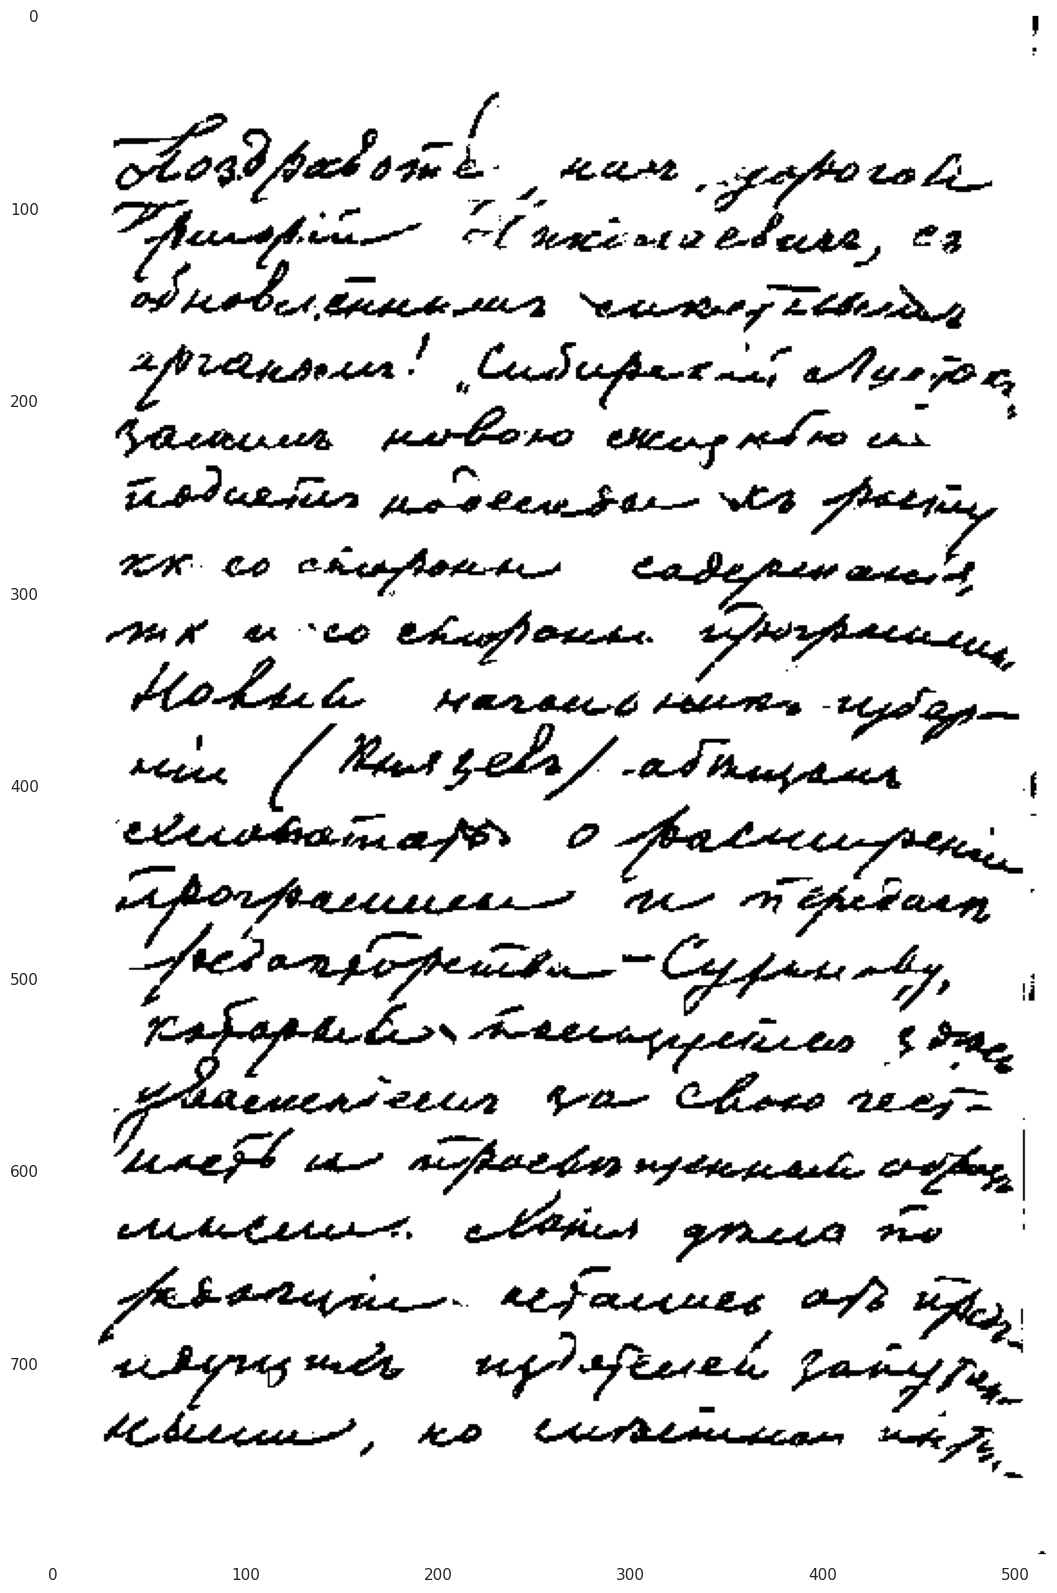

In [ ]:
plt.figure(figsize=(20, 20))

image = Image.open('КККМFOLDER_bin/Фарафонтова Таисия Михайловна/КККМ ОФ 7928:1207 Фарафонтова.png')

plt.imshow(image) #, cmap="grey")
plt.grid(False)
plt.show()

In [ ]:
x_items = d["x_items"]
x_items.shape

torch.Size([5, 177, 3, 300, 300])

In [ ]:
x_items[0][0].shape

torch.Size([3, 300, 300])

In [ ]:
# d["pred"], d["prob"], d["y_items"], d["x_items"], d["acc"]

In [ ]:
d["x_items"].shape

torch.Size([5, 177, 3, 300, 300])

In [ ]:
d["prob"].shape

torch.Size([5, 177, 3])

In [ ]:
d["pred"].shape, d["prob"].shape, d["y_items"].shape, d["x_items"].shape

(torch.Size([5, 177]),
 torch.Size([5, 177, 3]),
 torch.Size([5, 177]),
 torch.Size([5, 177, 3, 300, 300]))

In [ ]:
d["pred"].shape, d["prob"].shape, d["y_items"].shape, d["x_items"].shape

(torch.Size([177]),
 torch.Size([177, 3]),
 torch.Size([177]),
 torch.Size([5, 177, 3, 300, 300]))

In [ ]:
for i in range(10):
    print(d["y_items"][i])

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


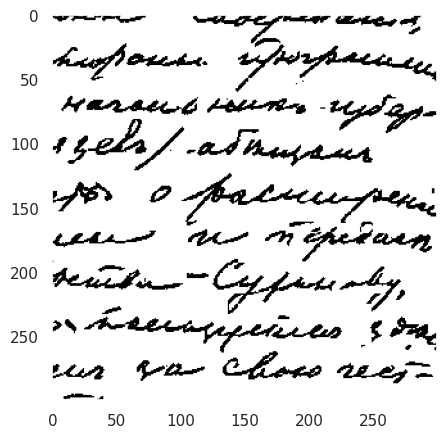

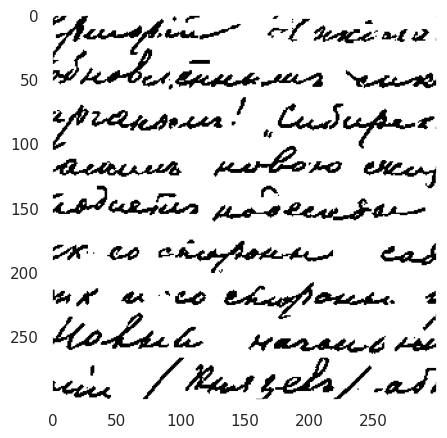

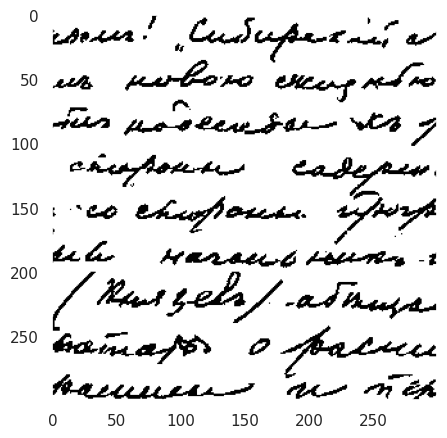

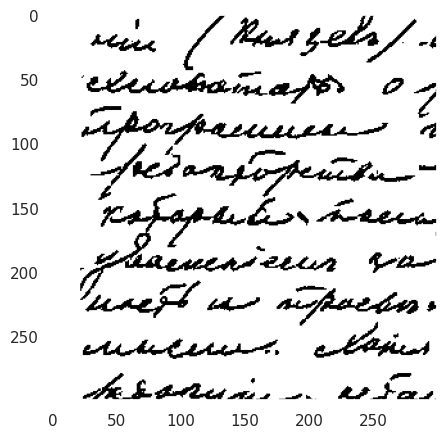

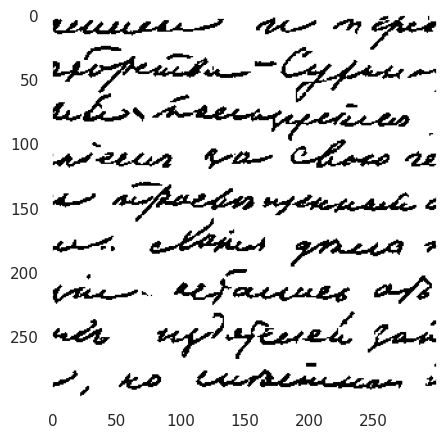

In [ ]:
for i in range(5):
    img = x_items[i][0]

    plt.figure(figsize=(5, 5))
    plt.imshow(img.permute(1, 2, 0).numpy()) #, cmap="grey")
    plt.grid(False)
    plt.show()

In [ ]:
train_dataset[0][0].shape

torch.Size([1000])

In [ ]:
47 / 141

0.3333333333333333

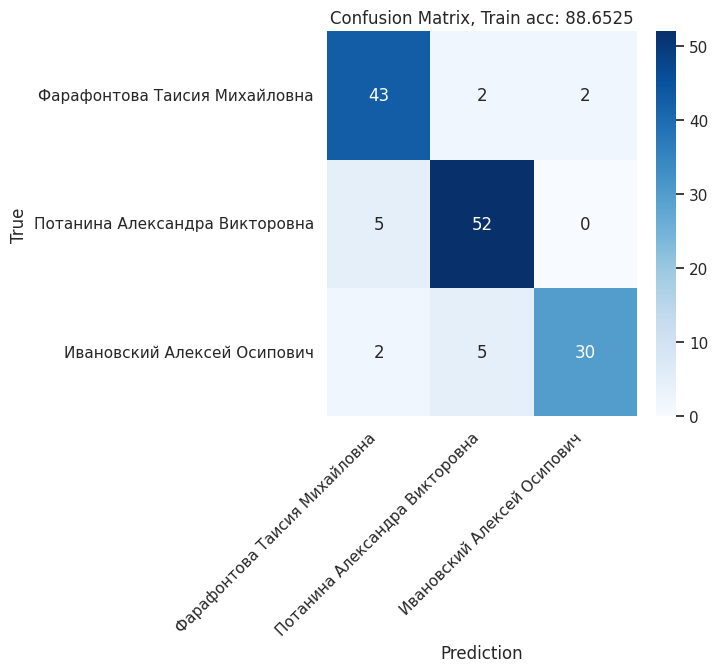

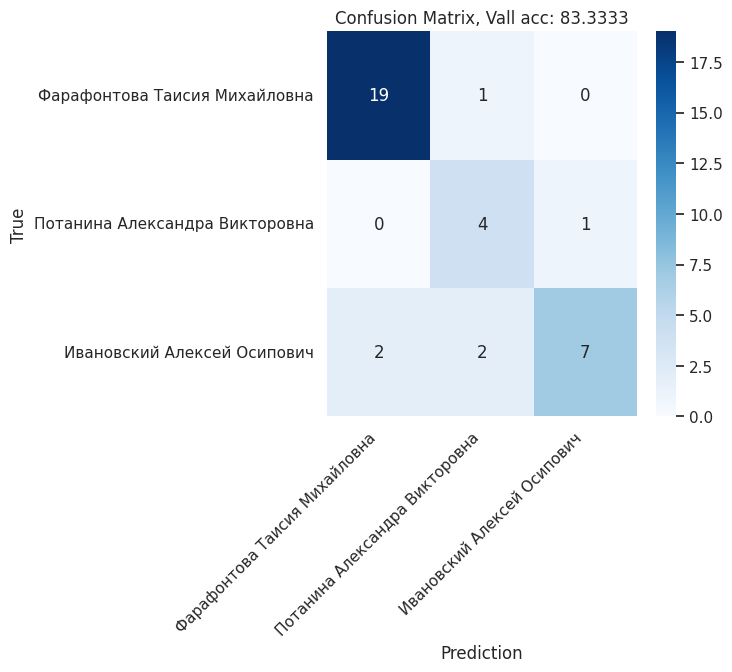

In [ ]:
# start ensemble
# d["pred"], d["prob"], d["y_items"], d["x_items"], d["acc"]
d = evaluation(cl_model, train_dataset, batch_size=config["batch_size"], n_epochs=1)
conf_matrix(d["y_items"], d["pred"], dataset.cls2dir, prop=False, title=f'Train acc: {d["acc"]:.6g}', savepath = os.path.join(dir, "train_conf.pdf"))
# conf_matrix(d["y_items"], d["pred"], dataset.cls2dir, prop=True, title=f'Train acc: {d["acc"]:.6g}', savepath = os.path.join(dir, "train_conf_prop.pdf"))

d = evaluation(cl_model, test_dataset, batch_size=config["batch_size"], n_epochs=1)
conf_matrix(d["y_items"], d["pred"], dataset.cls2dir, prop=False, title=f'Vall acc: {d["acc"]:.6g}', savepath = os.path.join(dir, "val_conf.pdf"))
# conf_matrix(d["y_items"], d["pred"], dataset.cls2dir, prop=True, title=f'Vall acc: {d["acc"]:.6g}', savepath = os.path.join(dir, "val_conf_prop.pdf"))

In [ ]:
d = evaluation(cl_model, train_dataset, batch_size=config["batch_size"], n_epochs=5)

d = evaluation(cl_model, test_dataset, batch_size=config["batch_size"], n_epochs=5)

In [ ]:
x_items = d["x_items"]
x_items.shape

torch.Size([5, 36, 1000])

In [ ]:
plt.figure(figsize=(5, 5))


plt.imshow(img) #, cmap="grey")

# New Dataset

In [ ]:
dataset = My_Folder("КККМFOLDER_bin", transform=transforms.ToTensor(), topk=20)
dataset.dir2count, dataset.cls2count, len(dataset)

({'Фарафонтова Таисия Михайловна': 67,
  'Потанина Александра Викторовна': 62,
  'Ивановский Алексей Осипович': 48,
  'Крутовский Владимир Михайлович': 46,
  'Свентицкая Мария Хрисанфовна': 35,
  'Вагнер (Дзвонкевич) Екатерина Николаевна': 32,
  'Антонова Валентина Константиновна': 31,
  'Проскурякова Е. Павловна': 30,
  'Семидалов Вениамин Иванович': 30,
  'Мендельсон Николай Михайлович': 29,
  'Крутовская Лидия Симоновна': 29,
  'Ржавская Надежда Федоровна': 28,
  'Попов Иван Иванович': 25,
  'Серошевский Вацлав Леопольдович': 25,
  'Адрианов Александр Васильевич': 23,
  'Анучин Дмитрий Николаевич': 22,
  'Козьмин Николай Николаевич': 21,
  'Пантелеев Лонгин Федорович': 19,
  'Руднев Андрей Дмитриевич': 19,
  'Гуркин Григорий Иванович': 18},
 {0: 67,
  1: 62,
  2: 48,
  3: 46,
  4: 35,
  5: 32,
  6: 31,
  7: 30,
  8: 30,
  9: 29,
  10: 29,
  11: 28,
  12: 25,
  13: 25,
  14: 23,
  15: 22,
  16: 21,
  17: 19,
  18: 19,
  19: 18},
 639)

In [ ]:
train_dataset, test_dataset = My_Balanced_split_dataset("КККМFOLDER_bin", transform=transforms.ToTensor(), topk=20, percent=0.8, type="siam")

In [ ]:
train_dataset.dir2count, train_dataset.cls2count, len(train_dataset)

({'Фарафонтова Таисия Михайловна': 53,
  'Потанина Александра Викторовна': 49,
  'Ивановский Алексей Осипович': 38,
  'Крутовский Владимир Михайлович': 36,
  'Свентицкая Мария Хрисанфовна': 28,
  'Вагнер (Дзвонкевич) Екатерина Николаевна': 25,
  'Антонова Валентина Константиновна': 24,
  'Проскурякова Е. Павловна': 24,
  'Семидалов Вениамин Иванович': 24,
  'Мендельсон Николай Михайлович': 23,
  'Крутовская Лидия Симоновна': 23,
  'Ржавская Надежда Федоровна': 22,
  'Попов Иван Иванович': 20,
  'Серошевский Вацлав Леопольдович': 20,
  'Адрианов Александр Васильевич': 18,
  'Анучин Дмитрий Николаевич': 17,
  'Козьмин Николай Николаевич': 16,
  'Пантелеев Лонгин Федорович': 15,
  'Руднев Андрей Дмитриевич': 15,
  'Гуркин Григорий Иванович': 14},
 {0: 53,
  1: 49,
  2: 38,
  3: 36,
  4: 28,
  5: 25,
  6: 24,
  7: 24,
  8: 24,
  9: 23,
  10: 23,
  11: 22,
  12: 20,
  13: 20,
  14: 18,
  15: 17,
  16: 16,
  17: 15,
  18: 15,
  19: 14},
 504)

In [ ]:
test_dataset.dir2count, test_dataset.cls2count, len(test_dataset)

({'Фарафонтова Таисия Михайловна': 14,
  'Потанина Александра Викторовна': 13,
  'Ивановский Алексей Осипович': 10,
  'Крутовский Владимир Михайлович': 10,
  'Свентицкая Мария Хрисанфовна': 7,
  'Вагнер (Дзвонкевич) Екатерина Николаевна': 7,
  'Антонова Валентина Константиновна': 7,
  'Проскурякова Е. Павловна': 6,
  'Семидалов Вениамин Иванович': 6,
  'Мендельсон Николай Михайлович': 6,
  'Крутовская Лидия Симоновна': 6,
  'Ржавская Надежда Федоровна': 6,
  'Попов Иван Иванович': 5,
  'Серошевский Вацлав Леопольдович': 5,
  'Адрианов Александр Васильевич': 5,
  'Анучин Дмитрий Николаевич': 5,
  'Козьмин Николай Николаевич': 5,
  'Пантелеев Лонгин Федорович': 4,
  'Руднев Андрей Дмитриевич': 4,
  'Гуркин Григорий Иванович': 4},
 {0: 14,
  1: 13,
  2: 10,
  3: 10,
  4: 7,
  5: 7,
  6: 7,
  7: 6,
  8: 6,
  9: 6,
  10: 6,
  11: 6,
  12: 5,
  13: 5,
  14: 5,
  15: 5,
  16: 5,
  17: 4,
  18: 4,
  19: 4},
 135)

In [ ]:
train_dataset.cls2paths[9]

['КККМFOLDER_bin/Мендельсон Николай Михайлович/КККМ ОФ 7928:1497 Мендельсон.png',
 'КККМFOLDER_bin/Мендельсон Николай Михайлович/КККМ ОФ 7928:1973 Мендельсон.png',
 'КККМFOLDER_bin/Мендельсон Николай Михайлович/КККМ ОФ 7928:1974 Мендельсон.png',
 'КККМFOLDER_bin/Мендельсон Николай Михайлович/КККМ ОФ 7928:1975 Мендельсон.png',
 'КККМFOLDER_bin/Мендельсон Николай Михайлович/КККМ ОФ 7928:1976 Мендельсон.png',
 'КККМFOLDER_bin/Мендельсон Николай Михайлович/КККМ ОФ 7928:1978 Мендельсон.png',
 'КККМFOLDER_bin/Мендельсон Николай Михайлович/КККМ ОФ 7928:1979 Мендельсон.png',
 'КККМFOLDER_bin/Мендельсон Николай Михайлович/КККМ ОФ 7928:2458 Мендельсон.png',
 'КККМFOLDER_bin/Мендельсон Николай Михайлович/КККМ ОФ 7928:764 Мендельсон.png',
 'КККМFOLDER_bin/Мендельсон Николай Михайлович/КККМ ОФ 7928:767 Мендельсон.png',
 'КККМFOLDER_bin/Мендельсон Николай Михайлович/КККМ ОФ 7928:768 Мендельсон.png',
 'КККМFOLDER_bin/Мендельсон Николай Михайлович/КККМ ОФ 7928:770 Мендельсон.pn

In [ ]:
test_dataset.cls2paths[9]

['КККМFOLDER_bin/Мендельсон Николай Михайлович/КККМ ОФ 7928:1972 Мендельсон.png',
 'КККМFOLDER_bin/Мендельсон Николай Михайлович/КККМ ОФ 7928:1977 Мендельсон.png',
 'КККМFOLDER_bin/Мендельсон Николай Михайлович/КККМ ОФ 7928:769 Мендельсон.png',
 'КККМFOLDER_bin/Мендельсон Николай Михайлович/КККМ ОФ 7928:772 Мендельсон.png',
 'КККМFOLDER_bin/Мендельсон Николай Михайлович/КККМ ОФ 7928:776 Мендельсон.png',
 'КККМFOLDER_bin/Мендельсон Николай Михайлович/КККМ ОФ 7928:779 Мендельсон.png']

In [ ]:
FOLDER_STROKES_BIN_OK = "КККМFOLDER_strokes_bin_ok"

print(len(recur_paths(FOLDER_STROKES_BIN_OK)))
print(len(os.listdir(FOLDER_STROKES_BIN_OK)))

36016
793


In [ ]:
dataset = My_Dataset("КККМFOLDER_strokes_bin_ok", transform=transforms.ToTensor(), topk=10)
dataset.dir2count, dataset.cls2count, len(dataset)

({'Потанина Александра Викторовна': 1384,
  'Фарафонтова Таисия Михайловна': 775,
  'Вагнер (Дзвонкевич) Екатерина Николаевна': 706,
  'Крутовский Владимир Михайлович': 678,
  'Ивановский Алексей Осипович': 664,
  'Антонова Валентина Константиновна': 544,
  'Семидалов Вениамин Иванович': 518,
  'Проскурякова Е. Павловна': 489,
  'Крутовская Лидия Симоновна': 462,
  'Ржавская Надежда Федоровна': 450},
 {0: 1384,
  1: 775,
  2: 706,
  3: 678,
  4: 664,
  5: 544,
  6: 518,
  7: 489,
  8: 462,
  9: 450},
 6670)

In [ ]:
cls2count = defaultdict(int)

for batch in tqdm(dataset):
    _, cls = batch
    cls2count[cls] += 1

sorted(cls2count.items()), sum(cls2count.values())

100%|██████████| 6670/6670 [00:00<00:00, 568652.72it/s]


([(0, 680),
  (1, 690),
  (2, 651),
  (3, 668),
  (4, 660),
  (5, 682),
  (6, 689),
  (7, 639),
  (8, 674),
  (9, 637)],
 6670)

In [ ]:
train_dataset, test_dataset = split_My_Dataset(dataset)
train_dataset.dir2count, train_dataset.cls2count, len(train_dataset), fun(train_dataset)

100%|██████████| 5361/5361 [00:00<00:00, 638380.14it/s]


({'Потанина Александра Викторовна': 1100,
  'Фарафонтова Таисия Михайловна': 624,
  'Вагнер (Дзвонкевич) Екатерина Николаевна': 572,
  'Крутовский Владимир Михайлович': 543,
  'Ивановский Алексей Осипович': 553,
  'Антонова Валентина Константиновна': 433,
  'Семидалов Вениамин Иванович': 411,
  'Проскурякова Е. Павловна': 401,
  'Крутовская Лидия Симоновна': 360,
  'Ржавская Надежда Федоровна': 364},
 {0: 1100,
  1: 624,
  2: 572,
  3: 543,
  4: 553,
  5: 433,
  6: 411,
  7: 401,
  8: 360,
  9: 364},
 5361,
 ([(0, 549),
   (1, 517),
   (2, 529),
   (3, 556),
   (4, 521),
   (5, 535),
   (6, 527),
   (7, 547),
   (8, 537),
   (9, 543)],
  5361))

In [ ]:
test_dataset.dir2count, test_dataset.cls2count, len(test_dataset), fun(test_dataset)

100%|██████████| 1309/1309 [00:00<00:00, 452550.60it/s]


({'Потанина Александра Викторовна': 284,
  'Фарафонтова Таисия Михайловна': 151,
  'Вагнер (Дзвонкевич) Екатерина Николаевна': 134,
  'Крутовский Владимир Михайлович': 135,
  'Ивановский Алексей Осипович': 111,
  'Антонова Валентина Константиновна': 111,
  'Семидалов Вениамин Иванович': 107,
  'Проскурякова Е. Павловна': 88,
  'Крутовская Лидия Симоновна': 102,
  'Ржавская Надежда Федоровна': 86},
 {0: 284,
  1: 151,
  2: 134,
  3: 135,
  4: 111,
  5: 111,
  6: 107,
  7: 88,
  8: 102,
  9: 86},
 1309,
 ([(0, 151),
   (1, 132),
   (2, 128),
   (3, 130),
   (4, 133),
   (5, 127),
   (6, 128),
   (7, 129),
   (8, 139),
   (9, 112)],
  1309))

In [ ]:
def fun(dataset):
    cls2count = defaultdict(int)

    for batch in tqdm(dataset):
        _, cls = batch
        cls2count[cls] += 1

    return sorted(cls2count.items()), sum(cls2count.values())

In [ ]:
cls2count = defaultdict(int)

for batch in tqdm(dataset):
    _, cls = batch
    cls2count[cls] += 1

cls2count

100%|██████████| 6670/6670 [00:00<00:00, 610363.43it/s]


defaultdict(int,
            {0: 1384,
             1: 775,
             2: 706,
             3: 678,
             4: 664,
             5: 544,
             6: 518,
             7: 489,
             8: 462,
             9: 450})

# strokes

In [ ]:
PAD_ID = -1

def pad_collate(batch):
    # BATCH_SIZE * C * EMB_SIZE x SEQ_LEN
    list_tensors, list_targets = zip(*batch)
    # print(len(list_tersors), len(list_targets))
    # print(list_tersors[0].shape)
    ans = [None] * len(list_tensors)
    # tokens_len = [None] * len(list_tersors)
    # masks = [None] * len(list_tersors)

    for i in range(len(list_tensors)):
        # tokens_len[i] = list_tensors[i].shape[-1] # SEQ_LEN
        ans[i] = list_tensors[i].permute(2, 0, 1) # C x EMB_SIZE x SEQ_LEN -> SEQ_LEN x C x EMB_SIZE

    # BATCH_SIZE * SEQ_LEN * C * EMB_SIZE ->
    # -> BATCH_SIZE x C x EMB_SIZE x SEQ_LEN
    return pad_sequence(ans, batch_first=True, padding_value=PAD_ID).permute(0, 2, 3, 1), torch.tensor(list_targets)


def pad(ans):
    return pad_sequence(ans, batch_first=True, padding_value=PAD_ID).permute(0, 2, 3, 1)

def pad_collate_siam(batch):
    # BATCH_SIZE * C * EMB_SIZE x SEQ_LEN
    list_tensors1, list_tensors2, list_tensors3 = zip(*batch)
    batch_size = len(list_tensors1)
    list_tensors = list_tensors1 + list_tensors2 + list_tensors3

    ans = [None] * len(list_tensors)
    # tokens_len = [None] * len(list_tersors)
    # masks = [None] * len(list_tersors)

    for i in range(len(list_tensors)):
        # tokens_len[i] = list_tensors[i].shape[-1] # SEQ_LEN
        ans[i] = list_tensors[i].permute(2, 0, 1) # C x EMB_SIZE x SEQ_LEN -> SEQ_LEN x C x EMB_SIZE

    # BATCH_SIZE * SEQ_LEN * C * EMB_SIZE ->
    # -> BATCH_SIZE x C x EMB_SIZE x SEQ_LEN

    ans1, ans2, ans3 = ans[:batch_size], ans[batch_size : 2 * batch_size], ans[2 * batch_size:]
    return pad(ans1), pad(ans2), pad(ans3)

In [ ]:
transform = transforms.Compose(
    [
            transforms.ToTensor(),
            Min_size(50),
    ])
dataset = My_TripletDataset("КККМFOLDER_strokes_bin_ok", transform=transform, topk=3)
BATCH_SIZE = 64

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate_siam)

In [ ]:
class NetworkStrokes(nn.Module):
    def __init__(self, in_channels=3, out_channels=10, emb_size=18, hid_size=128, output_emb = 1000, num_layers=1):
        super().__init__()
        self.CNN = nn.Sequential(
                     nn.Conv2d(in_channels=in_channels, out_channels=3, kernel_size=3),
                     nn.BatchNorm2d(3),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2, stride=(2, 3)),

                     nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3),
                     nn.BatchNorm2d(5),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2, stride=(1, 3)),

                     nn.Conv2d(in_channels=5, out_channels=out_channels, kernel_size=3),
                     nn.BatchNorm2d(10),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2, stride=(1, 2)),
                     )

        self.linear = nn.Linear(out_channels, 1)

        self.LSTM = nn.LSTM(input_size=emb_size, # emb_size зависит от CNN
                            hidden_size=hid_size,
                            num_layers=num_layers,
                            batch_first=True)

        self.classifier = nn.Sequential(nn.Linear(hid_size, output_emb))

    def forward(self, x):
        # x ~ BATCH_SIZE x C x EMB_SIZE x SEQ_LEN
        # tokens_lens ~ BATCH_SIZE
        mask = (x != PAD_ID).int()
        # print(x.shape, mask.shape)
        # print(1, x.shape)
        x = self.CNN(x) # BATCH_SIZE x out_channels x EMB_SIZE_new x SEQ_LEN_new
        # print(2, x.shape)
        x = x.permute(0, 2, 3, 1) # BATCH_SIZE x EMB_SIZE_new x SEQ_LEN_new x out_channels
        x = self.linear(x).squeeze(dim=-1) # BATCH_SIZE x EMB_SIZE_new x SEQ_LEN_new
        x = x.permute(0, 2, 1) # BATCH_SIZE x SEQ_LEN_new x EMB_SIZE_new


        mask = mask[:, 0, 0, ::18] # BATCH_SIZE x SEQ_LEN_new
        mask = mask[:, :x.shape[1]]

        # print(3, x.shape)
        x, _ = self.LSTM(x) # BATCH_SIZE x SEQ_LEN_new x HIDDEN_SIZE

        # print(x.shape, mask.shape)
        x = x * mask[..., None] # BATCH_SIZE x SEQ_LEN_new x HIDDEN_SIZE

        sum = x.sum(dim = 1) # BATCH_SIZE x HIDDEN_SIZE
        col = mask.sum(dim = 1) # BATCH_SIZE

        x = sum / col[..., None]
        # x = x.mean(dim = 1)
        # last_hid_idxs = (tokens_lens / 18).to(int) - 1
        # last_hid_idxs = (tokens_lens / 18).to(int) - 5
        # x = x[torch.arange(len(tokens_lens)), last_hid_idxs - 1, :] # BATCH_SIZE x HIDDEN_SIZE
        # BATCH_SIZE x HIDDEN_SIZE
        return self.classifier(x)


In [ ]:
transform = transforms.Compose(
    [
            transforms.ToTensor(),
            Min_size(50),

    ])


model = NetworkStrokes().to(DEVICE)
print(f"Parameters number: {number_of_parameters(model)}")
dataset = My_Dataset("КККМFOLDER_strokes_bin_ok", transform=transform, topk=3)
test_pipeline(model, dataset, pad_collate, DEVICE, batch_size=64)

Parameters number: 205507
X_batch: torch.Size([64, 3, 50, 1150])
y_batch: torch.Size([64])
model:   torch.Size([64, 1000])


In [ ]:
dataset.dir2count

{'Потанина Александра Викторовна': 1384,
 'Фарафонтова Таисия Михайловна': 775,
 'Вагнер (Дзвонкевич) Екатерина Николаевна': 706}

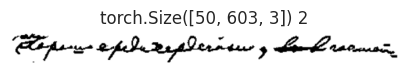

In [ ]:
img, cls = dataset[7]
img = img.permute(1, 2, 0)

plt.figure(figsize=(5, 1))
plt.imshow(img, cmap="grey")
plt.title(f"{img.shape} {cls}")
plt.axis(False)
plt.show()

In [ ]:
# cl_model = NetworkStrokes().to(DEVICE).to(DEVICE)
# print(f"Parameters number: {number_of_parameters(cl_model)}")

# # transform = transforms.ToTensor()
# transform = transforms.Compose(
#     [
#             transforms.ToTensor(),
#             Min_size(50),
#     ])

# dataset = My_Dataset("КККМFOLDER_strokes_bin_ok", transform=transform, topk=3)
# print(len(dataset))
# train_dataset, test_dataset = split_dataset(dataset)
# print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")

# optimizer = torch.optim.Adam(cl_model.parameters(), lr=3e-4)
# criterion = torch.nn.CrossEntropyLoss()

# BATCH_SIZE = 64
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)
# val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate)

# trainer = Trainer(cl_model, optimizer, criterion, type = "not siam", dir = "logs", name = "strokes_cl3")

# trainer.train(train_loader, val_loader, n_epochs = 20)

In [ ]:
# print(f"Device: {DEVICE}")

# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(DEVICE)
# emb_dim = 1000
# model = create_model(model, num_freeze_layers=9, num_out_classes=emb_dim).to(DEVICE)
# print(f"Parameters number: {number_of_parameters(model)}")

# # transform = transforms.ToTensor()
# transform = transforms.Compose(
#     [
#             transforms.RandomCrop(300),
#             transforms.CenterCrop(224),
#             # transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=255),
#             transforms.ToTensor(),
#     ])


# dataset = My_TripletDataset("КККМFOLDER_strokes_bin_ok", transform)
# print(len(dataset))
# train_dataset, test_dataset = split_dataset(dataset)
# print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")

# optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# criterion = torch.nn.TripletMarginLoss(margin=9, p=2)

# BATCH_SIZE = 64
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# trainer = Trainer(model, optimizer, criterion, type = "siam", dir = "logs", name = "siam3")

# trainer.train(train_loader, val_loader, n_epochs = 30)

In [ ]:
print(f"Device: {DEVICE}")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(DEVICE)
emb_dim = 1000
model = create_model(model, num_freeze_layers=9, num_out_classes=emb_dim).to(DEVICE)
print(f"Parameters number: {number_of_parameters(model)}")

transform = transforms.Compose(
    [
            transforms.ToTensor(),
            Min_size(50),
    ])

dataset = My_TripletDataset("КККМFOLDER_strokes_bin_ok", transform=transform, topk=3)
print(len(dataset))
train_dataset, test_dataset = split_dataset(dataset)
print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.TripletMarginLoss(margin=9, p=2)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate_siam)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate_siam)

trainer = Trainer(model, optimizer, criterion, type = "siam", dir = "logs", name = "siamstrokes3")

trainer.train(train_loader, val_loader, n_epochs = 30)

Device: cuda
Parameters number: 513000
2865
split_dataset: Train: 2292 Test: 573 Total: 2865
train dataset: 2292, test dataset: 573
Make logs/2025-04-14 13:44:13 siamstrokes3


  0%|          | 0/36 [00:00<?, ?it/s]

00:02:20 epoch:   0, train/val loss = 6.53507 / 4.35934, acc = 72.73124 / 82.02443


  0%|          | 0/36 [00:00<?, ?it/s]

00:03:09 epoch:   1, train/val loss = 4.13470 / 3.86047, acc = 81.63176 / 84.46771


  0%|          | 0/36 [00:00<?, ?it/s]

00:03:54 epoch:   2, train/val loss = 3.45215 / 3.29028, acc = 85.25305 / 85.51483


  0%|          | 0/36 [00:00<?, ?it/s]

00:04:33 epoch:   3, train/val loss = 3.36968 / 2.89409, acc = 85.20942 / 87.43455


  0%|          | 0/36 [00:00<?, ?it/s]

00:05:12 epoch:   4, train/val loss = 3.00916 / 3.24813, acc = 86.34380 / 85.86387


  0%|          | 0/36 [00:00<?, ?it/s]

00:05:48 epoch:   5, train/val loss = 2.89885 / 2.93280, acc = 87.08551 / 87.43455


  0%|          | 0/36 [00:00<?, ?it/s]

00:06:32 epoch:   6, train/val loss = 3.01781 / 3.84590, acc = 86.08202 / 81.67539


  0%|          | 0/36 [00:00<?, ?it/s]

00:07:10 epoch:   7, train/val loss = 2.80276 / 2.53884, acc = 88.56894 / 90.05236


  0%|          | 0/36 [00:00<?, ?it/s]

00:07:47 epoch:   8, train/val loss = 2.68474 / 2.81639, acc = 88.21990 / 87.60908


  0%|          | 0/36 [00:00<?, ?it/s]

00:08:22 epoch:   9, train/val loss = 2.66477 / 2.63439, acc = 88.61257 / 88.13264


  0%|          | 0/36 [00:00<?, ?it/s]

00:08:58 epoch:  10, train/val loss = 2.64977 / 2.43716, acc = 88.13264 / 89.17976


  0%|          | 0/36 [00:00<?, ?it/s]

00:09:34 epoch:  11, train/val loss = 2.95979 / 2.74629, acc = 87.08551 / 88.48168


  0%|          | 0/36 [00:00<?, ?it/s]

00:10:14 epoch:  12, train/val loss = 2.45319 / 2.54585, acc = 89.57243 / 89.00524


  0%|          | 0/36 [00:00<?, ?it/s]

00:10:50 epoch:  13, train/val loss = 2.51557 / 2.45657, acc = 88.74346 / 90.05236


  0%|          | 0/36 [00:00<?, ?it/s]

00:11:37 epoch:  14, train/val loss = 2.54234 / 2.28112, acc = 88.69983 / 90.57592


  0%|          | 0/36 [00:00<?, ?it/s]

00:12:16 epoch:  15, train/val loss = 2.51886 / 2.94940, acc = 89.39791 / 86.91099


  0%|          | 0/36 [00:00<?, ?it/s]

00:12:59 epoch:  16, train/val loss = 2.25915 / 2.79659, acc = 90.00873 / 88.13264


  0%|          | 0/36 [00:00<?, ?it/s]

00:13:44 epoch:  17, train/val loss = 2.31769 / 2.50304, acc = 90.27051 / 87.95812


  0%|          | 0/36 [00:00<?, ?it/s]

00:14:32 epoch:  18, train/val loss = 2.16701 / 2.14649, acc = 90.79407 / 90.75044


  0%|          | 0/36 [00:00<?, ?it/s]

00:15:17 epoch:  19, train/val loss = 2.35532 / 1.55328, acc = 89.92147 / 93.89180


  0%|          | 0/36 [00:00<?, ?it/s]

00:15:53 epoch:  20, train/val loss = 2.28831 / 2.35775, acc = 90.09599 / 89.52880


  0%|          | 0/36 [00:00<?, ?it/s]

00:16:40 epoch:  21, train/val loss = 2.34888 / 2.20467, acc = 89.87784 / 90.57592


  0%|          | 0/36 [00:00<?, ?it/s]

00:17:16 epoch:  22, train/val loss = 2.18917 / 2.10114, acc = 90.05236 / 92.49564


  0%|          | 0/36 [00:00<?, ?it/s]

00:18:04 epoch:  23, train/val loss = 2.20442 / 2.08453, acc = 90.61955 / 91.44852


  0%|          | 0/36 [00:00<?, ?it/s]

00:18:45 epoch:  24, train/val loss = 2.39804 / 2.18848, acc = 89.35428 / 90.40140


  0%|          | 0/36 [00:00<?, ?it/s]

00:19:28 epoch:  25, train/val loss = 2.37055 / 2.00557, acc = 89.92147 / 91.09948


  0%|          | 0/36 [00:00<?, ?it/s]

00:20:09 epoch:  26, train/val loss = 2.15667 / 2.17692, acc = 90.57592 / 90.40140


  0%|          | 0/36 [00:00<?, ?it/s]

00:20:59 epoch:  27, train/val loss = 2.24613 / 2.42342, acc = 90.27051 / 88.83072


  0%|          | 0/36 [00:00<?, ?it/s]

00:21:35 epoch:  28, train/val loss = 2.17151 / 2.07066, acc = 91.09948 / 91.27400


  0%|          | 0/36 [00:00<?, ?it/s]

00:22:12 epoch:  29, train/val loss = 2.38545 / 1.98356, acc = 89.65969 / 91.79756
Val losses doesn`t decrease!


In [ ]:
num_classes = 3
cl_model = nn.Sequential(nn.Linear(emb_dim, 512), nn.ReLU(), nn.Linear(512, num_classes)).to(DEVICE)
print(f"Parameters number: {number_of_parameters(cl_model)}")

model.eval()
for p in model.parameters():
    p.requires_grad = False
print(f"Parameters number: {number_of_parameters(model)}")

# transform = transforms.ToTensor()
transform = transforms.Compose(
    [
            transforms.ToTensor(),
            Min_size(50),
            ToModel(model, DEVICE),
    ])

dataset = My_Dataset("КККМFOLDER_strokes_bin_ok", transform=transform, topk=3)
print(len(dataset))
train_dataset, test_dataset = split_dataset(dataset)
print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")

optimizer = torch.optim.Adam(cl_model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

trainer = Trainer(cl_model, optimizer, criterion, type = "not siam", dir = "logs", name = "clstrokes3")

trainer.train(train_loader, val_loader, n_epochs = 20)

Parameters number: 514051
Parameters number: 0
2865
split_dataset: Train: 2292 Test: 573 Total: 2865
train dataset: 2292, test dataset: 573
Make logs/2025-04-14 14:06:27 clstrokes3


  0%|          | 0/36 [00:00<?, ?it/s]

00:00:24 epoch:   0, train/val loss = 0.24487 / 0.18651, acc = 91.57941 / 94.58988


  0%|          | 0/36 [00:00<?, ?it/s]

00:00:44 epoch:   1, train/val loss = 0.23647 / 0.24119, acc = 92.27749 / 92.32112


  0%|          | 0/36 [00:00<?, ?it/s]

00:01:04 epoch:   2, train/val loss = 0.20303 / 0.20218, acc = 92.75742 / 93.71728


  0%|          | 0/36 [00:00<?, ?it/s]

00:01:26 epoch:   3, train/val loss = 0.19987 / 0.17240, acc = 93.41187 / 93.19372


  0%|          | 0/36 [00:00<?, ?it/s]

00:01:57 epoch:   4, train/val loss = 0.19242 / 0.19236, acc = 93.10646 / 93.54276


  0%|          | 0/36 [00:00<?, ?it/s]

00:02:19 epoch:   5, train/val loss = 0.18062 / 0.13505, acc = 94.02269 / 96.16056


  0%|          | 0/36 [00:00<?, ?it/s]

00:02:41 epoch:   6, train/val loss = 0.18328 / 0.17801, acc = 93.36824 / 94.58988


  0%|          | 0/36 [00:00<?, ?it/s]

00:03:02 epoch:   7, train/val loss = 0.18376 / 0.17352, acc = 93.71728 / 94.24084


  0%|          | 0/36 [00:00<?, ?it/s]

00:03:22 epoch:   8, train/val loss = 0.15818 / 0.10873, acc = 94.28447 / 96.50960


  0%|          | 0/36 [00:00<?, ?it/s]

00:03:46 epoch:   9, train/val loss = 0.16065 / 0.13275, acc = 94.28447 / 95.63700


  0%|          | 0/36 [00:00<?, ?it/s]

00:04:12 epoch:  10, train/val loss = 0.14551 / 0.11867, acc = 95.02618 / 95.11344


  0%|          | 0/36 [00:00<?, ?it/s]

00:04:44 epoch:  11, train/val loss = 0.15630 / 0.10953, acc = 94.32810 / 95.81152


  0%|          | 0/36 [00:00<?, ?it/s]

00:05:13 epoch:  12, train/val loss = 0.13668 / 0.12659, acc = 95.11344 / 96.50960


  0%|          | 0/36 [00:00<?, ?it/s]

00:05:32 epoch:  13, train/val loss = 0.14442 / 0.14487, acc = 95.15707 / 94.06632


  0%|          | 0/36 [00:00<?, ?it/s]

00:05:52 epoch:  14, train/val loss = 0.13451 / 0.12402, acc = 95.37522 / 95.81152


  0%|          | 0/36 [00:00<?, ?it/s]

00:06:25 epoch:  15, train/val loss = 0.11676 / 0.11069, acc = 96.11693 / 96.16056


  0%|          | 0/36 [00:00<?, ?it/s]

00:06:51 epoch:  16, train/val loss = 0.12066 / 0.10707, acc = 95.72426 / 96.50960


  0%|          | 0/36 [00:00<?, ?it/s]

00:07:19 epoch:  17, train/val loss = 0.11415 / 0.12814, acc = 96.46597 / 96.16056


  0%|          | 0/36 [00:00<?, ?it/s]

00:07:48 epoch:  18, train/val loss = 0.10189 / 0.09535, acc = 96.55323 / 96.68412


  0%|          | 0/36 [00:00<?, ?it/s]

00:08:15 epoch:  19, train/val loss = 0.11645 / 0.08011, acc = 96.29145 / 97.38220


# Eval

tensor(96.7277)


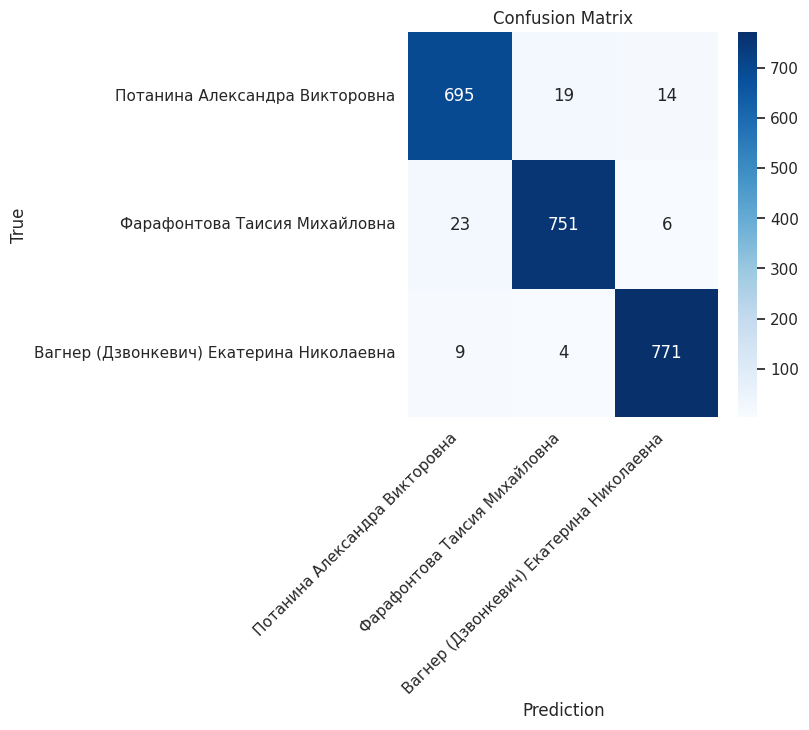

In [ ]:
y_pred, y_prob, y_true, acc = eval(cl_model, train_loader)
y_pred, y_prob, y_true, acc = y_pred.cpu(), y_prob.cpu(), y_true.cpu(), acc.cpu()
print(acc)
conf_matrix(y_true, y_pred, dataset.cls2dir)

tensor(96.6841)


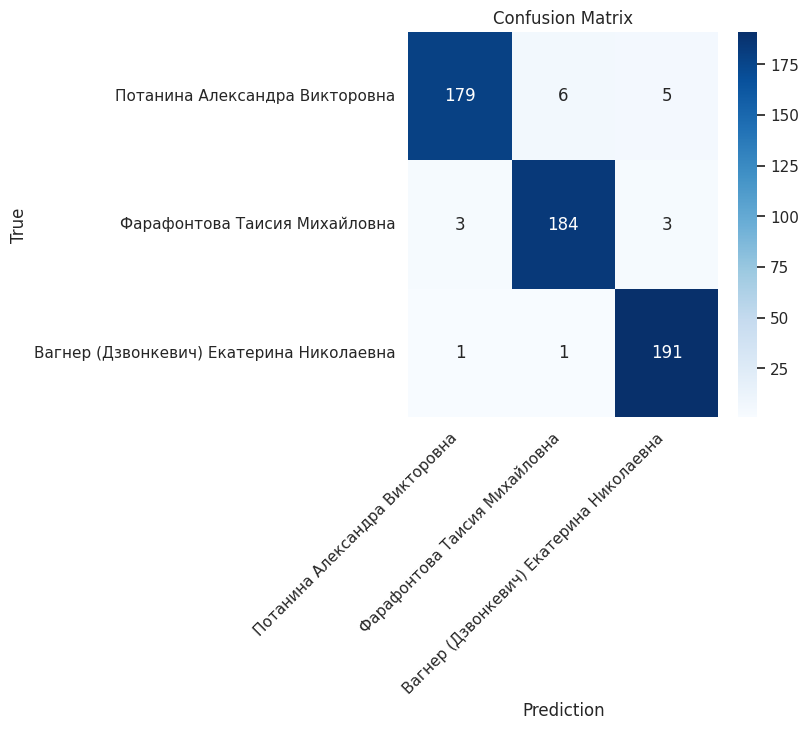

In [ ]:
y_pred, y_prob, y_true, acc = eval(cl_model, val_loader)
y_pred, y_prob, y_true, acc = y_pred.cpu(), y_prob.cpu(), y_true.cpu(), acc.cpu()
print(acc)
conf_matrix(y_true, y_pred, dataset.cls2dir)

In [ ]:
transform = transforms.Compose(
    [
            transforms.ToTensor(),
            Min_size(50),
            ToModel(model, DEVICE),
    ])

dataset = My_TestDataset("КККМFOLDER_strokes_bin_ok", transform=transform, topk=3)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

y_pred, y_prob, y_true, acc = eval(cl_model, loader)
y_pred, y_prob, y_true, acc = y_pred.cpu(), y_prob.cpu(), y_true.cpu(), acc.cpu()
paths = [i[0] for i in dataset.dataset]
acc, len(paths), len(y_prob)

(tensor(96.5096), 2865, 2865)

In [ ]:
y_prob.shape

torch.Size([2865, 3])

In [ ]:
paths2prob = {}

for path, prob in zip(paths, y_prob):
    paths2prob[path] = prob

In [ ]:
images2strokes = defaultdict(list)

def namefile(path):
    return path.split("/")[-1]

for path in paths:
    # path ~ КККМ ОФ 7928:98 Агафонов # 2.png

    _, cls, picname = path.split("/")

    picname = os.path.splitext(picname)[0]

    name, num_str = picname.split(" # ")

    num_pic, *_ = name.strip().split()[2:] # "КККМ", "ОФ" выкинуть

    images2strokes[num_pic].append((path, cls))

In [ ]:
list_pred = []
list_true = []

fails = []

for image, paths in images2strokes.items():
    paths, classes = zip(*paths)
    cls = classes[0]

    list_probs = [paths2prob[path] for path in paths]
    list_probs = torch.vstack(list_probs)

    prob_optimal = torch.mean(list_probs, dim=0)

    pred = torch.argmax(prob_optimal).item()
    true = dataset.dir2cls[cls]

    if pred != true:
        fails.append(image)

    list_pred.append(pred)
    list_true.append(true)

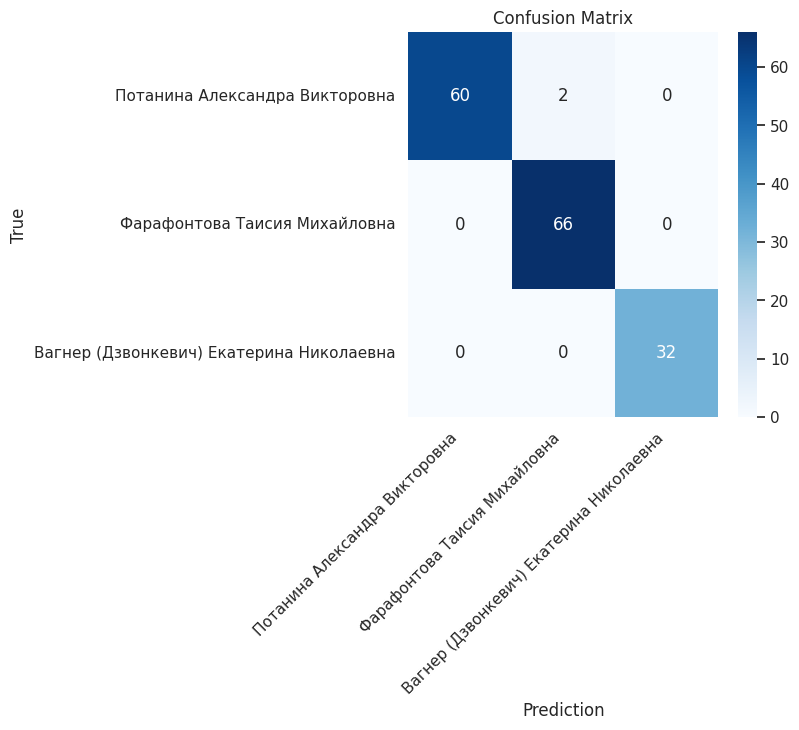

In [ ]:
conf_matrix(list_true, list_pred, dataset.cls2dir)

In [ ]:
fails

['7928:2684', '7928:2693']

In [ ]:
!unzip КККМFOLDER_bin.zip -d "."

Archive:  КККМFOLDER_bin.zip
   creating: ./КККМFOLDER_bin/
   creating: ./КККМFOLDER_bin/Васильева-Потанина Мария Георгиевна/
  inflating: ./КККМFOLDER_bin/Васильева-Потанина Мария Георгиевна/КККМ ОФ 7928:1516 Васильева.png  
   creating: ./КККМFOLDER_bin/Ляпустин А./
  inflating: ./КККМFOLDER_bin/Ляпустин А./КККМ ОФ 7928:1963 Ляпустин.png  
   creating: ./КККМFOLDER_bin/Бабанина Елена/
  inflating: ./КККМFOLDER_bin/Бабанина Елена/КККМ ОФ 7928:214 Бабанина.png  
  inflating: ./КККМFOLDER_bin/Бабанина Елена/КККМ ОФ 7928:215 Бабанина.png  
  inflating: ./КККМFOLDER_bin/Бабанина Елена/КККМ ОФ 7928:1582 Бабанина.png  
   creating: ./КККМFOLDER_bin/Мокиевская & Мокиевский П. & Выхарева & Юферова & Лихарева/
  inflating: ./КККМFOLDER_bin/Мокиевская & Мокиевский П. & Выхарева & Юферова & Лихарева/КККМ ОФ 7928:1485 Мокиевские и др.png  
   creating: ./КККМFOLDER_bin/Управляющий фабрики в с. Колыванское/
  inflating: ./КККМFOLDER_bin/Управляющий фабрики в с. Колыванское/КККМ ОФ 7928:1378 Управ

In [ ]:
ls

 demo.ipynb              КККМfolder3_bin/
 kraken_example2.ipynb   КККМfolder3_strokes_bin/
 kraken_example.ipynb   'КККМfolder3_strokes_bin (1)'/
 logs/                   КККМfolder9_bin/
'Potanin (1).ipynb'      КККМFOLDER_bin/
 Potanin.ipynb           КККМFOLDER_bin.zip
 weights/                КККМFOLDER_strokes_bin_ok/
 Zhukovsky/              КККМFOLDER_strokes_bin_ok.zip
 КККМ_bin.zip


# End